<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>

In [ ]:
# !pip install torch-summary

In [ ]:
import os
from google.colab import drive
from pathlib import Path
from tqdm import tqdm, tqdm_notebook
from time import time

# что то связанное с сериализацией данных
import pickle
# Что то для мультипроцессинга
from multiprocessing.pool import ThreadPool

import numpy as np
import pandas as pd
from matplotlib import colors, pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_splitF
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
torch.use_deterministic_algorithms(True)

import PIL
from PIL import Image

from torchsummary import summary

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
# Монитруем диск (необходимо при работе с гугл колабом)
drive.mount('/content/gdrive/', force_remount=True)

# Распаковываем архив с картинками 
!unrar x -inul /content/gdrive/MyDrive/PH2Dataset.rar

Mounted at /content/gdrive/


In [ ]:
# Проверяем нличие гпу
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Устанавливаем девайс
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

CUDA is available!  Training on GPU ...


In [ ]:
# Список путей до картинок
image_files = []
# Список путей до результатов сегментации
lesion_files = []
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        image_files.append(os.path.join(root, files[0]))
    if root.endswith('_lesion'):
        lesion_files.append(os.path.join(root, files[0]))

In [ ]:
# Датасет
class segmentation(Dataset):
    """
    Датасет с картинками и результатами сегментации 
    """
    # Получаем на вход список путей к картинками и результатам сегментации
    def __init__(self, image_files, seg_files, input_size):
        super().__init__()
        self.input_size = input_size

        # список файлов для загрузки
        self.image_files = sorted(image_files)
        self.seg_files = sorted(seg_files)
        
        # Определяем переменную для метода длины датасета
        self.len_ = len(self.image_files)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        # Тут мы открываем нашу картинку
        image = Image.open(file)
        # Выгружаем пиксели
        image.load()
        return image
  
    def __getitem__(self, index):
        # Перевод в нужный размер и в тензоры
        transform = transforms.Compose([
            transforms.Resize(size=(self.input_size, self.input_size)),
            transforms.ToTensor(), # переводит в интервал от 0 до 1
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        # Загружаем картинку по пути, используя конкретный индекс
        x = self.load_sample(self.image_files[index])
        x = transform(x)

        y = self.load_sample(self.seg_files[index])
        y = transform(y)

        return x, y

In [ ]:
# Делим на трейн, вал, тест и определяем датасеты
# Разделим наши 200 картинок на 100/50/50 для обучения, валидации и теста соответственно

ix = np.random.choice(len(image_files), len(image_files), False)
tr, val, ts = np.split(ix, [100, 150])

tr_image_files, val_image_files, test_image_files  = [image_files[x] for x in tr], [image_files[x] for x in val], \
                                                     [image_files[x] for x in ts]

tr_seg_files, val_seg_files, test_seg_files  = [lesion_files[x] for x in tr], [lesion_files[x] for x in val], \
                                               [lesion_files[x] for x in ts]

train_dataset = segmentation(image_files=tr_image_files, seg_files=tr_seg_files, input_size=256)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=20)

val_dataset = segmentation(image_files=val_image_files, seg_files=val_seg_files, input_size=256)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=20)

test_dataset = segmentation(image_files=test_image_files, seg_files=test_seg_files, input_size=256)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=20)

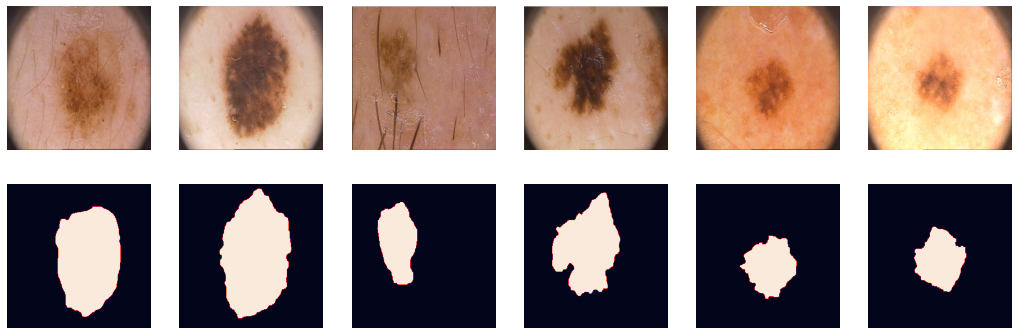

In [ ]:
plt.figure(figsize=(18, 6))
random_image = int(np.random.uniform(0,50))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(train_dataset[random_image+i][0].numpy().transpose((1, 2, 0)))

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(train_dataset[random_image+i][1].numpy()[0])
plt.show()

## Задание:
1. Написать архитектуры SegNet и U-Net для решения задачи семантической сегментации.  
2. Испробовать различные лосс функции.  
3. Сравнить качество моделей на тесте. 
 

## Метрика:
В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.

Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.detach()
    outputs = torch.sigmoid(outputs)
    outputs = torch.round(outputs)
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W

    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs.int() & labels.int()).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs.int() | labels.int()).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return torch.mean(iou) # torch.mean(thresholded)

## Функция потерь

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_pred, y_real):
    y_real = y_real.view(1,-1).squeeze()
    y_pred = y_pred.view(1,-1).squeeze()

    loss = torch.clamp(y_pred, 0) - y_pred * y_real + torch.log(1+torch.exp(-torch.abs(y_pred)))
    return torch.mean(loss)

## Дополнительные функции потерь [2 балла] 

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real):
    eps = 1e-4
    y_pred = torch.sigmoid(y_pred)

    num = torch.sum(2 * y_real * y_pred)
    den =  torch.sum(y_real + y_pred + eps)

    res = 1 - ((num / den)) # (1/(256*256)) * 
    return res 

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-4, gamma = 2):
    real = y_real.contiguous().view(1,-1).squeeze()
    pred = y_pred.contiguous().view(1,-1).squeeze()
    pred = torch.sigmoid(pred)
    pred = torch.clamp(pred, eps, 1. - eps)

    comp_1 = (1 - pred)**gamma
    comp_2 = real * torch.log(pred)
    comp_3 = (1-real) * torch.log(1-pred)
    loss = - torch.mean(comp_1 * comp_2 + comp_3)
    return loss

## 3. Custom loss
**TverskyLoss**

In [ ]:
ALPHA = 0.5
BETA = 0.5
GAMMA = 1

def FocalTverskyLoss(y_pred, y_real, alpha=ALPHA, beta=BETA, gamma=GAMMA, eps = 1e-4):
    
    pred = torch.sigmoid(y_pred)
    pred = torch.clamp(pred, eps, 1. - eps)       
    
    pred = pred.view(-1)
    y_real = y_real.view(-1)
    
    TP = (pred * y_real).sum()    
    FP = ((1-y_real) * pred).sum()
    FN = (y_real * (1-pred)).sum()
    
    Tversky = (TP + eps) / (TP + alpha*FP + beta*FN + eps)  
    FocalTversky = (1 - Tversky)**gamma
                    
    return FocalTversky

## SegNet


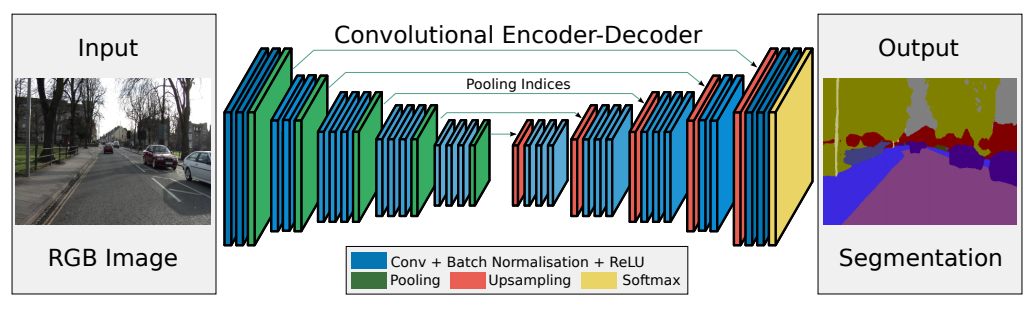

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder (downsampling)
        # enc_conv0
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # enc_conv1
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)

        # enc_conv2
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # enc_conv3
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        # dec_conv_0
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # dec_conv_1
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # dec_conv_2
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # dec_conv_3
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0, id_0 = self.pool0(e0)

        e1 = self.enc_conv1(e0)
        e1, id_1 = self.pool1(e1)

        e2 = self.enc_conv2(e1)
        e2, id_2 = self.pool2(e2)

        e3 = self.enc_conv3(e2)
        e3, id_3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.upsample0(b, id_3)
        d0 = self.dec_conv0(d0)

        d1 = self.upsample1(d0, id_2)
        d1 = self.dec_conv1(d1)
 
        d2 = self.upsample2(d1, id_1)
        d2 = self.dec_conv2(d2)

        d3 = self.upsample3(d2, id_0)
        d3 = self.dec_conv3(d3)

        return d3

In [ ]:
def visualisation(X_val, Y_val, model):

    model.eval()
    inputs = X_val.to(DEVICE)
    Y_hat = model(inputs)
    Y_hat = Y_hat.detach().cpu()
    Y_hat = torch.sigmoid(Y_hat)
    Y_hat[Y_hat>0.5]=1
    Y_hat[Y_hat<=0.5]=0

    # Visualize tools
    # clear_output(wait=True)
    f = plt.figure(figsize=(15,7))
    for k in range(6):
        plt.subplot(2, 6, k+1,)
        plt.imshow(Y_val[k, 0])
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(Y_hat[k, 0])
        plt.title('Output')
        plt.axis('off')
    plt.show()

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    loss_avg = 0
    train_iou  = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_iou += iou_pytorch(outputs, labels)
        loss_avg += loss.item()

        optimizer.zero_grad()

    train_iou /= len(train_loader)
    train_loss = loss_avg / len(train_loader)
    return train_loss, train_iou

def eval_epoch(model, val_loader, criterion):
    model.eval()
    loss_avg = 0
    val_iou  = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        val_iou += iou_pytorch(outputs, labels)
        loss_avg += loss.item()

    val_iou /= len(val_loader)
    val_loss = loss_avg / len(val_loader)
    return val_loss, val_iou

def train(train_loader, val_loader, model, epochs, opt, criterion):

    X_val, Y_val = next(iter(val_loader))

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_iou {train_iou:0.4f} val_iou {val_iou:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)

        for epoch in range(epochs):
            train_loss, train_iou = fit_epoch(model, train_loader, criterion, opt)
            
            val_loss, val_iou = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_iou, val_loss, val_iou))
            
            exp_lr_scheduler.step()

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, v_loss=val_loss, \
                                           train_iou=train_iou, val_iou=val_iou))
        
    visualisation(X_val, Y_val, model)
            
    return history

def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch) for X_batch, _ in data]
    return np.array(Y_pred)

def score_model(model, metric, data):
    model.eval() 
    scores = []
    with torch.no_grad():
        for X_batch, Y_label in data:
            X_batch = X_batch.to(DEVICE)
            Y_pred = model(X_batch)
            scores.append(metric(Y_pred.cpu(), Y_label))
    return scores

In [ ]:
summary(model, (3,256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
       BatchNorm2d-6         [-1, 64, 256, 256]             128
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

epoch:   5%|▍         | 1/21 [00:03<01:09,  3.50s/it]


Epoch 001 train_loss: 0.6135     val_loss 0.5797 train_iou 0.2427 val_iou 0.2731


epoch:  10%|▉         | 2/21 [00:06<01:06,  3.50s/it]


Epoch 002 train_loss: 0.5122     val_loss 0.5306 train_iou 0.3234 val_iou 0.3691


epoch:  14%|█▍        | 3/21 [00:10<01:02,  3.50s/it]


Epoch 003 train_loss: 0.4280     val_loss 0.4699 train_iou 0.4966 val_iou 0.4396


epoch:  19%|█▉        | 4/21 [00:13<00:59,  3.49s/it]


Epoch 004 train_loss: 0.3787     val_loss 0.3892 train_iou 0.6278 val_iou 0.4993


epoch:  24%|██▍       | 5/21 [00:17<00:55,  3.49s/it]


Epoch 005 train_loss: 0.3315     val_loss 0.3385 train_iou 0.6567 val_iou 0.5610


epoch:  29%|██▊       | 6/21 [00:20<00:52,  3.49s/it]


Epoch 006 train_loss: 0.2945     val_loss 0.3948 train_iou 0.6812 val_iou 0.4303


epoch:  33%|███▎      | 7/21 [00:24<00:48,  3.49s/it]


Epoch 007 train_loss: 0.2479     val_loss 0.3248 train_iou 0.7050 val_iou 0.5007


epoch:  38%|███▊      | 8/21 [00:27<00:45,  3.49s/it]


Epoch 008 train_loss: 0.2233     val_loss 0.2370 train_iou 0.7107 val_iou 0.6389


epoch:  43%|████▎     | 9/21 [00:31<00:41,  3.49s/it]


Epoch 009 train_loss: 0.2080     val_loss 0.2102 train_iou 0.7413 val_iou 0.6828


epoch:  48%|████▊     | 10/21 [00:34<00:38,  3.49s/it]


Epoch 010 train_loss: 0.2250     val_loss 0.1951 train_iou 0.7232 val_iou 0.7132


epoch:  52%|█████▏    | 11/21 [00:38<00:34,  3.49s/it]


Epoch 011 train_loss: 0.2187     val_loss 0.1824 train_iou 0.7463 val_iou 0.7512


epoch:  57%|█████▋    | 12/21 [00:41<00:31,  3.50s/it]


Epoch 012 train_loss: 0.1985     val_loss 0.1781 train_iou 0.7592 val_iou 0.7659


epoch:  62%|██████▏   | 13/21 [00:45<00:27,  3.50s/it]


Epoch 013 train_loss: 0.2126     val_loss 0.1779 train_iou 0.7445 val_iou 0.7715


epoch:  67%|██████▋   | 14/21 [00:48<00:24,  3.50s/it]


Epoch 014 train_loss: 0.2011     val_loss 0.1792 train_iou 0.7451 val_iou 0.7707


epoch:  71%|███████▏  | 15/21 [00:52<00:20,  3.50s/it]


Epoch 015 train_loss: 0.1959     val_loss 0.1783 train_iou 0.7645 val_iou 0.7718


epoch:  76%|███████▌  | 16/21 [00:55<00:17,  3.50s/it]


Epoch 016 train_loss: 0.2048     val_loss 0.1780 train_iou 0.7506 val_iou 0.7722


epoch:  81%|████████  | 17/21 [00:59<00:13,  3.50s/it]


Epoch 017 train_loss: 0.2132     val_loss 0.1792 train_iou 0.7446 val_iou 0.7701


epoch:  86%|████████▌ | 18/21 [01:02<00:10,  3.50s/it]


Epoch 018 train_loss: 0.2036     val_loss 0.1792 train_iou 0.7544 val_iou 0.7702


epoch:  90%|█████████ | 19/21 [01:06<00:07,  3.50s/it]


Epoch 019 train_loss: 0.1834     val_loss 0.1784 train_iou 0.7762 val_iou 0.7710


epoch:  95%|█████████▌| 20/21 [01:09<00:03,  3.51s/it]


Epoch 020 train_loss: 0.1946     val_loss 0.1781 train_iou 0.7602 val_iou 0.7713


epoch: 100%|██████████| 21/21 [01:13<00:00,  3.50s/it]



Epoch 021 train_loss: 0.1882     val_loss 0.1770 train_iou 0.7689 val_iou 0.7723


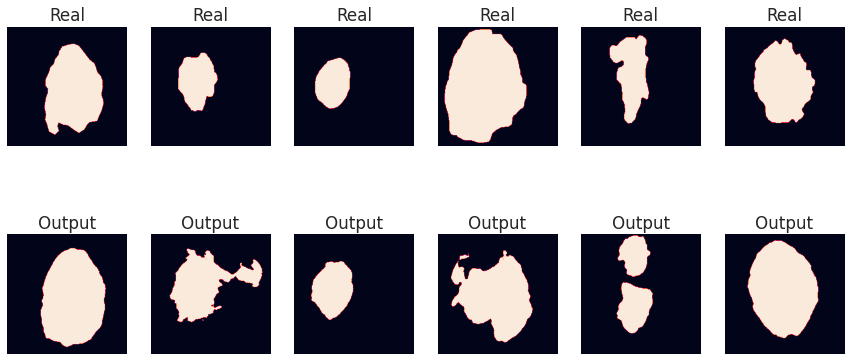

epoch:   5%|▍         | 1/21 [00:03<01:09,  3.50s/it]


Epoch 001 train_loss: 0.5991     val_loss 0.6824 train_iou 0.0996 val_iou 0.0000


epoch:  10%|▉         | 2/21 [00:06<01:06,  3.50s/it]


Epoch 002 train_loss: 0.4211     val_loss 5.9200 train_iou 0.4910 val_iou 0.0070


epoch:  14%|█▍        | 3/21 [00:10<01:02,  3.49s/it]


Epoch 003 train_loss: 0.3505     val_loss 24.4061 train_iou 0.6381 val_iou 0.0040


epoch:  19%|█▉        | 4/21 [00:13<00:59,  3.50s/it]


Epoch 004 train_loss: 0.2875     val_loss 9.9475 train_iou 0.6765 val_iou 0.0128


epoch:  24%|██▍       | 5/21 [00:17<00:55,  3.49s/it]


Epoch 005 train_loss: 0.2742     val_loss 7.8534 train_iou 0.7021 val_iou 0.0502


epoch:  29%|██▊       | 6/21 [00:20<00:52,  3.49s/it]


Epoch 006 train_loss: 0.2617     val_loss 5.9751 train_iou 0.7094 val_iou 0.0901


epoch:  33%|███▎      | 7/21 [00:24<00:48,  3.49s/it]


Epoch 007 train_loss: 0.2342     val_loss 0.5173 train_iou 0.7242 val_iou 0.5145


epoch:  38%|███▊      | 8/21 [00:27<00:45,  3.49s/it]


Epoch 008 train_loss: 0.2466     val_loss 0.4696 train_iou 0.7481 val_iou 0.5246


epoch:  43%|████▎     | 9/21 [00:31<00:41,  3.49s/it]


Epoch 009 train_loss: 0.2171     val_loss 0.3989 train_iou 0.7501 val_iou 0.6520


epoch:  48%|████▊     | 10/21 [00:34<00:38,  3.50s/it]


Epoch 010 train_loss: 0.2281     val_loss 0.2975 train_iou 0.7610 val_iou 0.7358


epoch:  52%|█████▏    | 11/21 [00:38<00:34,  3.50s/it]


Epoch 011 train_loss: 0.2145     val_loss 0.2653 train_iou 0.7561 val_iou 0.7482


epoch:  57%|█████▋    | 12/21 [00:41<00:31,  3.50s/it]


Epoch 012 train_loss: 0.2111     val_loss 0.2460 train_iou 0.7701 val_iou 0.7591


epoch:  62%|██████▏   | 13/21 [00:45<00:27,  3.50s/it]


Epoch 013 train_loss: 0.2162     val_loss 0.2389 train_iou 0.7626 val_iou 0.7631


epoch:  67%|██████▋   | 14/21 [00:48<00:24,  3.50s/it]


Epoch 014 train_loss: 0.2015     val_loss 0.2360 train_iou 0.7655 val_iou 0.7610


epoch:  71%|███████▏  | 15/21 [00:52<00:20,  3.50s/it]


Epoch 015 train_loss: 0.1866     val_loss 0.2371 train_iou 0.7804 val_iou 0.7594


epoch:  76%|███████▌  | 16/21 [00:55<00:17,  3.50s/it]


Epoch 016 train_loss: 0.1951     val_loss 0.2374 train_iou 0.7725 val_iou 0.7593


epoch:  81%|████████  | 17/21 [00:59<00:14,  3.50s/it]


Epoch 017 train_loss: 0.1942     val_loss 0.2377 train_iou 0.7818 val_iou 0.7589


epoch:  86%|████████▌ | 18/21 [01:02<00:10,  3.51s/it]


Epoch 018 train_loss: 0.1902     val_loss 0.2384 train_iou 0.7748 val_iou 0.7585


epoch:  90%|█████████ | 19/21 [01:06<00:07,  3.51s/it]


Epoch 019 train_loss: 0.1956     val_loss 0.2386 train_iou 0.7717 val_iou 0.7585


epoch:  95%|█████████▌| 20/21 [01:09<00:03,  3.50s/it]


Epoch 020 train_loss: 0.1920     val_loss 0.2394 train_iou 0.7701 val_iou 0.7581


epoch: 100%|██████████| 21/21 [01:13<00:00,  3.50s/it]



Epoch 021 train_loss: 0.2013     val_loss 0.2389 train_iou 0.7693 val_iou 0.7587


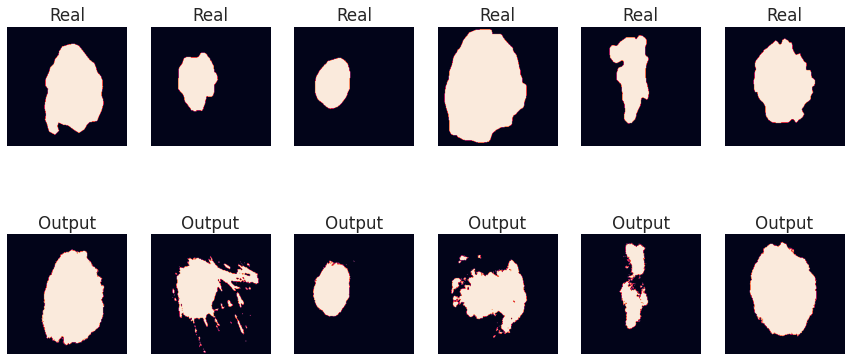

epoch:   5%|▍         | 1/21 [00:03<01:09,  3.47s/it]


Epoch 001 train_loss: 0.6133     val_loss 0.5786 train_iou 0.2605 val_iou 0.3706


epoch:  10%|▉         | 2/21 [00:06<01:06,  3.48s/it]


Epoch 002 train_loss: 0.5748     val_loss 0.5567 train_iou 0.3202 val_iou 0.3693


epoch:  14%|█▍        | 3/21 [00:10<01:02,  3.48s/it]


Epoch 003 train_loss: 0.5294     val_loss 0.5127 train_iou 0.3332 val_iou 0.3693


epoch:  19%|█▉        | 4/21 [00:13<00:59,  3.50s/it]


Epoch 004 train_loss: 0.4408     val_loss 0.4372 train_iou 0.3922 val_iou 0.3997


epoch:  24%|██▍       | 5/21 [00:17<00:56,  3.50s/it]


Epoch 005 train_loss: 0.3404     val_loss 0.4742 train_iou 0.5147 val_iou 0.3614


epoch:  29%|██▊       | 6/21 [00:21<00:52,  3.50s/it]


Epoch 006 train_loss: 0.2878     val_loss 0.4645 train_iou 0.5692 val_iou 0.3699


epoch:  33%|███▎      | 7/21 [00:24<00:48,  3.50s/it]


Epoch 007 train_loss: 0.2205     val_loss 0.4258 train_iou 0.6442 val_iou 0.3939


epoch:  38%|███▊      | 8/21 [00:28<00:45,  3.50s/it]


Epoch 008 train_loss: 0.1957     val_loss 0.2814 train_iou 0.6885 val_iou 0.5514


epoch:  43%|████▎     | 9/21 [00:31<00:42,  3.50s/it]


Epoch 009 train_loss: 0.1765     val_loss 0.2132 train_iou 0.7053 val_iou 0.6623


epoch:  48%|████▊     | 10/21 [00:35<00:38,  3.50s/it]


Epoch 010 train_loss: 0.1572     val_loss 0.1695 train_iou 0.7365 val_iou 0.7147


epoch:  52%|█████▏    | 11/21 [00:38<00:34,  3.50s/it]


Epoch 011 train_loss: 0.1623     val_loss 0.1550 train_iou 0.7406 val_iou 0.7324


epoch:  57%|█████▋    | 12/21 [00:42<00:31,  3.50s/it]


Epoch 012 train_loss: 0.1662     val_loss 0.1501 train_iou 0.7287 val_iou 0.7460


epoch:  62%|██████▏   | 13/21 [00:45<00:27,  3.50s/it]


Epoch 013 train_loss: 0.1393     val_loss 0.1471 train_iou 0.7606 val_iou 0.7551


epoch:  67%|██████▋   | 14/21 [00:49<00:24,  3.50s/it]


Epoch 014 train_loss: 0.1444     val_loss 0.1480 train_iou 0.7590 val_iou 0.7584


epoch:  71%|███████▏  | 15/21 [00:52<00:21,  3.50s/it]


Epoch 015 train_loss: 0.1452     val_loss 0.1467 train_iou 0.7517 val_iou 0.7592


epoch:  76%|███████▌  | 16/21 [00:56<00:17,  3.51s/it]


Epoch 016 train_loss: 0.1629     val_loss 0.1459 train_iou 0.7335 val_iou 0.7599


epoch:  81%|████████  | 17/21 [00:59<00:14,  3.51s/it]


Epoch 017 train_loss: 0.1752     val_loss 0.1453 train_iou 0.7323 val_iou 0.7607


epoch:  86%|████████▌ | 18/21 [01:03<00:10,  3.50s/it]


Epoch 018 train_loss: 0.1375     val_loss 0.1448 train_iou 0.7564 val_iou 0.7613


epoch:  90%|█████████ | 19/21 [01:06<00:07,  3.51s/it]


Epoch 019 train_loss: 0.1442     val_loss 0.1443 train_iou 0.7689 val_iou 0.7621


epoch:  95%|█████████▌| 20/21 [01:10<00:03,  3.51s/it]


Epoch 020 train_loss: 0.1524     val_loss 0.1436 train_iou 0.7469 val_iou 0.7625


epoch: 100%|██████████| 21/21 [01:13<00:00,  3.50s/it]



Epoch 021 train_loss: 0.1599     val_loss 0.1423 train_iou 0.7335 val_iou 0.7637


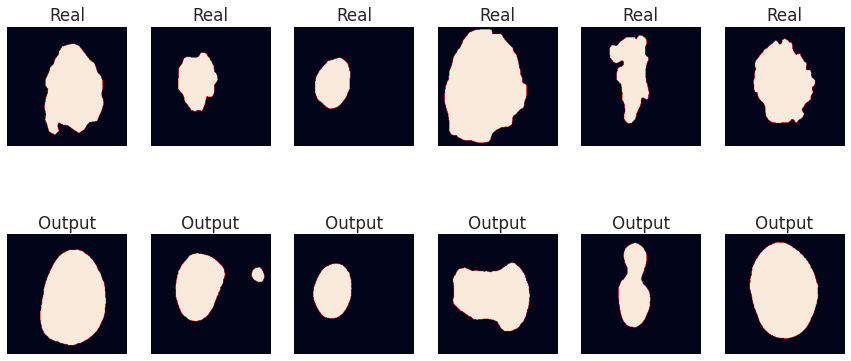

epoch:   5%|▍         | 1/21 [00:03<01:09,  3.49s/it]


Epoch 001 train_loss: 0.4497     val_loss 0.4803 train_iou 0.1058 val_iou 0.0000


epoch:  10%|▉         | 2/21 [00:07<01:06,  3.50s/it]


Epoch 002 train_loss: 0.3246     val_loss 0.4063 train_iou 0.0087 val_iou 0.0000


epoch:  14%|█▍        | 3/21 [00:10<01:02,  3.50s/it]


Epoch 003 train_loss: 0.2289     val_loss 0.3705 train_iou 0.5129 val_iou 0.0144


epoch:  19%|█▉        | 4/21 [00:14<00:59,  3.50s/it]


Epoch 004 train_loss: 0.1975     val_loss 0.3274 train_iou 0.6917 val_iou 0.3005


epoch:  24%|██▍       | 5/21 [00:17<00:55,  3.50s/it]


Epoch 005 train_loss: 0.1834     val_loss 0.6223 train_iou 0.6712 val_iou 0.3568


epoch:  29%|██▊       | 6/21 [00:21<00:52,  3.50s/it]


Epoch 006 train_loss: 0.1835     val_loss 0.5051 train_iou 0.6722 val_iou 0.5717


epoch:  33%|███▎      | 7/21 [00:24<00:48,  3.49s/it]


Epoch 007 train_loss: 0.1984     val_loss 0.2326 train_iou 0.7151 val_iou 0.6930


epoch:  38%|███▊      | 8/21 [00:27<00:45,  3.50s/it]


Epoch 008 train_loss: 0.1584     val_loss 0.1717 train_iou 0.7330 val_iou 0.7350


epoch:  43%|████▎     | 9/21 [00:31<00:41,  3.50s/it]


Epoch 009 train_loss: 0.1620     val_loss 0.1720 train_iou 0.7310 val_iou 0.7213


epoch:  48%|████▊     | 10/21 [00:34<00:38,  3.50s/it]


Epoch 010 train_loss: 0.1433     val_loss 0.1698 train_iou 0.7590 val_iou 0.7229


epoch:  52%|█████▏    | 11/21 [00:38<00:34,  3.50s/it]


Epoch 011 train_loss: 0.1527     val_loss 0.1625 train_iou 0.7443 val_iou 0.7359


epoch:  57%|█████▋    | 12/21 [00:41<00:31,  3.50s/it]


Epoch 012 train_loss: 0.1340     val_loss 0.1584 train_iou 0.7710 val_iou 0.7491


epoch:  62%|██████▏   | 13/21 [00:45<00:28,  3.50s/it]


Epoch 013 train_loss: 0.1299     val_loss 0.1527 train_iou 0.7737 val_iou 0.7570


epoch:  67%|██████▋   | 14/21 [00:49<00:24,  3.50s/it]


Epoch 014 train_loss: 0.1361     val_loss 0.1458 train_iou 0.7626 val_iou 0.7677


epoch:  71%|███████▏  | 15/21 [00:52<00:21,  3.50s/it]


Epoch 015 train_loss: 0.1358     val_loss 0.1445 train_iou 0.7704 val_iou 0.7711


epoch:  76%|███████▌  | 16/21 [00:55<00:17,  3.50s/it]


Epoch 016 train_loss: 0.1355     val_loss 0.1436 train_iou 0.7630 val_iou 0.7731


epoch:  81%|████████  | 17/21 [00:59<00:13,  3.49s/it]


Epoch 017 train_loss: 0.1454     val_loss 0.1430 train_iou 0.7532 val_iou 0.7745


epoch:  86%|████████▌ | 18/21 [01:02<00:10,  3.49s/it]


Epoch 018 train_loss: 0.1367     val_loss 0.1427 train_iou 0.7769 val_iou 0.7777


epoch:  90%|█████████ | 19/21 [01:06<00:06,  3.49s/it]


Epoch 019 train_loss: 0.1358     val_loss 0.1424 train_iou 0.7635 val_iou 0.7788


epoch:  95%|█████████▌| 20/21 [01:09<00:03,  3.50s/it]


Epoch 020 train_loss: 0.1310     val_loss 0.1426 train_iou 0.7651 val_iou 0.7804


epoch: 100%|██████████| 21/21 [01:13<00:00,  3.50s/it]



Epoch 021 train_loss: 0.1277     val_loss 0.1428 train_iou 0.7728 val_iou 0.7808


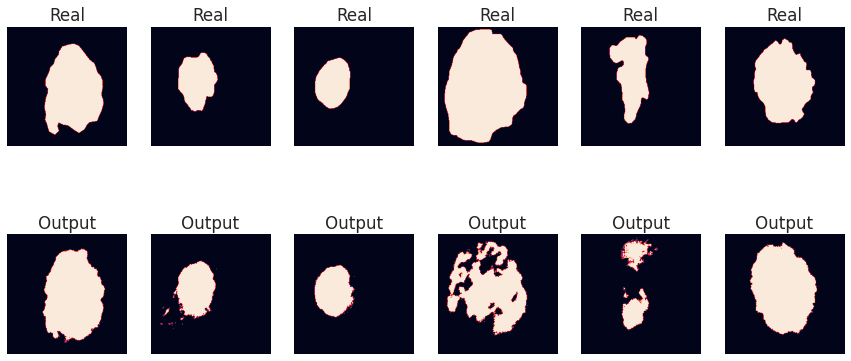

In [ ]:
torch.cuda.empty_cache()
model = SegNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_tver = train(train_dataloader, val_dataloader, model=model, epochs=21, opt=optimizer, criterion=FocalTverskyLoss)

torch.cuda.empty_cache()
model = SegNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_bce = train(train_dataloader, val_dataloader, model=model, epochs=21, opt=optimizer, criterion=bce_loss)

torch.cuda.empty_cache()
model = SegNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_dice = train(train_dataloader, val_dataloader, model=model, epochs=21, opt=optimizer, criterion=dice_loss)

torch.cuda.empty_cache()
model = SegNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_focal = train(train_dataloader, val_dataloader, model=model, epochs=21, opt=optimizer, criterion=focal_loss)


train_loss_tver, train_iou_tver, val_loss_tver, val_iou_tver = zip(*history_tver)
train_loss_bce, train_iou_bce, val_loss_bce, val_iou_bce = zip(*history_bce)
train_loss_dice, train_iou_dice, val_loss_dice, val_iou_dice = zip(*history_dice)
train_loss_focal, train_iou_focal, val_loss_focal, val_iou_focal = zip(*history_focal)

### U-net

In [ ]:
class UNet1(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # enc_conv1
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2,return_indices=True)

        # enc_conv2
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # enc_conv3
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)


        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )


        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # dec_conv_1
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # dec_conv_2
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # dec_conv_3
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) # 3 -> 64
        e0_p, id_0 = self.pool0(e0)

        e1 = self.enc_conv1(e0_p) # 64 -> 128
        e1_p, id_1 = self.pool1(e1)

        e2 = self.enc_conv2(e1_p) # 128 -> 256
        e2_p, id_2 = self.pool2(e2)

        e3 = self.enc_conv3(e2_p) # 256 -> 512
        e3_p, id_3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_p) # 512 -> 1024 -> 512

        # decoder
        d0 = self.upsample0(b, id_3)
        # print("shape of d_0:", d0.shape)
        # print("shape of e3:", e3.shape)
        cat_0 = torch.cat((d0, e3), dim=1)
        # print("shape of cat_0:", cat_0.shape)
        d0 = self.dec_conv0(cat_0) # 1024 -> 512 -> 256

        d1 = self.upsample1(d0, id_2)
        # print("shape of d_0:", d1.shape)
        # print("shape of e3:", e2.shape)
        cat_1 = torch.cat((d1, e2), dim=1)
        # print("shape of cat_1:", cat_1.shape)
        d1 = self.dec_conv1(cat_1) # 512 -> 256 -> 128
 
        d2 = self.upsample2(d1, id_1)
        # print("shape of d_0:", d2.shape)
        # print("shape of e3:", e1.shape)
        cat_2 = torch.cat((d2, e1), dim=1)
        # print("shape of cat_2:", cat_2.shape)
        d2 = self.dec_conv2(cat_2) # 256 -> 128 -> 64

        d3 = self.upsample3(d2, id_0)
        # print("shape of d_0:", d3.shape)
        # print("shape of e3:", e0.shape)
        cat_3 = torch.cat((d3, e0), dim=1)
        # print("shape of cat_3:", cat_3.shape)
        d3 = self.dec_conv3(cat_3) # 128 -> 64 -> 1
        return d3

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.downsample_0 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, stride=2, kernel_size=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # enc_conv1
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(), 
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.downsample_1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, stride=2, kernel_size=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # enc_conv2
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.downsample_2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, stride=2, kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # enc_conv3
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.downsample_3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, stride=2, kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )


        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )


        # decoder (upsampling)
        self.upsample_0 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=512, stride=2, kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # dec_conv_1
        self.upsample_1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, stride=2, kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        # dec_conv_2
        self.upsample_2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=128, stride=2, kernel_size=2),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        # dec_conv_3
        self.upsample_3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=64, stride=2, kernel_size=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x) # 3 -> 64
        # print("shape of e0:", e0.shape)
        e0_p = self.downsample_0(e0)
        # print("shape of e0_p:", e0_p.shape, "\n")

        e1 = self.enc_conv1(e0_p) # 64 -> 128
        # print("shape of e1:", e1.shape)
        e1_p = self.downsample_1(e1)
        # print("shape of e1_p:", e1_p.shape, "\n")

        e2 = self.enc_conv2(e1_p) # 128 -> 256
        # print("shape of e2:", e2.shape)
        e2_p = self.downsample_2(e2)
        # print("shape of e2_p:", e2_p.shape, "\n")

        e3 = self.enc_conv3(e2_p) # 256 -> 512
        # print("shape of e3:", e3.shape)
        e3_p = self.downsample_3(e3)
        # print("shape of e3_p:", e3_p.shape, "\n")

        # bottleneck
        b = self.bottleneck_conv(e3_p) # 512 -> 1024 -> 512
        # print("shape of bottleneck:", b.shape, "\n")

        # decoder
        d0 = self.upsample_0(b)
        # print("shape of d_0:", d0.shape)
        cat_0 = torch.cat((d0, e3), dim=1)
        # print("shape of cat_0:", cat_0.shape, "\n")
        d0 = self.dec_conv0(cat_0) # 1024 -> 512 -> 256

        d1 = self.upsample_1(d0)
        # print("shape of d_0:", d1.shape)
        cat_1 = torch.cat((d1, e2), dim=1)
        # print("shape of cat_1:", cat_1.shape, "\n")
        d1 = self.dec_conv1(cat_1) # 512 -> 256 -> 128
 
        d2 = self.upsample_2(d1)
        # print("shape of d_0:", d2.shape)
        cat_2 = torch.cat((d2, e1), dim=1)
        # print("shape of cat_2:", cat_2.shape, "\n")
        d2 = self.dec_conv2(cat_2) # 256 -> 128 -> 64

        d3 = self.upsample_3(d2)
        # print("shape of d_0:", d3.shape)
        cat_3 = torch.cat((d3, e0), dim=1)
        # print("shape of cat_3:", cat_3.shape, "\n")
        d3 = self.dec_conv3(cat_3) # 128 -> 64 -> 1
        return d3

In [ ]:
torch.cuda.empty_cache()
model = UNet1().to(DEVICE)
summary(model, (3,256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
              ReLU-5         [-1, 64, 256, 256]               0
       BatchNorm2d-6         [-1, 64, 256, 256]             128
         MaxPool2d-7  [[-1, 64, 128, 128], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14  [[

In [ ]:
torch.cuda.empty_cache()
model = UNet2().to(DEVICE)
summary(model, (3,256, 256))

shape of e0: torch.Size([2, 64, 256, 256])
shape of e0_p: torch.Size([2, 64, 128, 128]) 

shape of e1: torch.Size([2, 128, 128, 128])
shape of e1_p: torch.Size([2, 128, 64, 64]) 

shape of e2: torch.Size([2, 256, 64, 64])
shape of e2_p: torch.Size([2, 256, 32, 32]) 

shape of e3: torch.Size([2, 512, 32, 32])
shape of e3_p: torch.Size([2, 512, 16, 16]) 

shape of bottleneck: torch.Size([2, 512, 16, 16]) 

shape of d_0: torch.Size([2, 512, 32, 32])
shape of cat_0: torch.Size([2, 1024, 32, 32]) 

shape of d_0: torch.Size([2, 256, 64, 64])
shape of cat_1: torch.Size([2, 512, 64, 64]) 

shape of d_0: torch.Size([2, 128, 128, 128])
shape of cat_2: torch.Size([2, 256, 128, 128]) 

shape of d_0: torch.Size([2, 64, 256, 256])
shape of cat_3: torch.Size([2, 128, 256, 256]) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-

epoch:   4%|▎         | 1/28 [00:04<01:50,  4.11s/it]


Epoch 001 train_loss: 0.4724     val_loss 0.6010 train_iou 0.4198 val_iou 0.0000


epoch:   7%|▋         | 2/28 [00:08<01:46,  4.11s/it]


Epoch 002 train_loss: 0.3090     val_loss 0.6036 train_iou 0.5744 val_iou 0.1885


epoch:  11%|█         | 3/28 [00:12<01:42,  4.11s/it]


Epoch 003 train_loss: 0.2489     val_loss 0.5909 train_iou 0.6743 val_iou 0.0886


epoch:  14%|█▍        | 4/28 [00:16<01:38,  4.10s/it]


Epoch 004 train_loss: 0.2086     val_loss 0.5742 train_iou 0.7288 val_iou 0.1850


epoch:  18%|█▊        | 5/28 [00:20<01:34,  4.10s/it]


Epoch 005 train_loss: 0.1849     val_loss 0.4920 train_iou 0.7304 val_iou 0.2937


epoch:  21%|██▏       | 6/28 [00:24<01:30,  4.10s/it]


Epoch 006 train_loss: 0.1664     val_loss 0.3359 train_iou 0.7544 val_iou 0.4919


epoch:  25%|██▌       | 7/28 [00:28<01:26,  4.10s/it]


Epoch 007 train_loss: 0.1658     val_loss 0.3063 train_iou 0.7529 val_iou 0.5417


epoch:  29%|██▊       | 8/28 [00:32<01:22,  4.11s/it]


Epoch 008 train_loss: 0.1465     val_loss 0.2770 train_iou 0.7721 val_iou 0.5864


epoch:  32%|███▏      | 9/28 [00:36<01:17,  4.10s/it]


Epoch 009 train_loss: 0.1377     val_loss 0.2247 train_iou 0.7834 val_iou 0.6560


epoch:  36%|███▌      | 10/28 [00:41<01:13,  4.10s/it]


Epoch 010 train_loss: 0.1255     val_loss 0.1622 train_iou 0.7903 val_iou 0.7335


epoch:  39%|███▉      | 11/28 [00:45<01:09,  4.11s/it]


Epoch 011 train_loss: 0.1295     val_loss 0.1303 train_iou 0.7939 val_iou 0.7864


epoch:  43%|████▎     | 12/28 [00:49<01:05,  4.10s/it]


Epoch 012 train_loss: 0.1253     val_loss 0.1101 train_iou 0.8049 val_iou 0.8168


epoch:  46%|████▋     | 13/28 [00:53<01:01,  4.10s/it]


Epoch 013 train_loss: 0.1235     val_loss 0.1057 train_iou 0.8048 val_iou 0.8188


epoch:  50%|█████     | 14/28 [00:57<00:57,  4.10s/it]


Epoch 014 train_loss: 0.1298     val_loss 0.1048 train_iou 0.7994 val_iou 0.8235


epoch:  54%|█████▎    | 15/28 [01:01<00:53,  4.10s/it]


Epoch 015 train_loss: 0.1102     val_loss 0.1034 train_iou 0.8176 val_iou 0.8255


epoch:  57%|█████▋    | 16/28 [01:05<00:49,  4.10s/it]


Epoch 016 train_loss: 0.1082     val_loss 0.1023 train_iou 0.8178 val_iou 0.8270


epoch:  61%|██████    | 17/28 [01:09<00:45,  4.10s/it]


Epoch 017 train_loss: 0.1185     val_loss 0.1015 train_iou 0.8037 val_iou 0.8284


epoch:  64%|██████▍   | 18/28 [01:13<00:41,  4.11s/it]


Epoch 018 train_loss: 0.1134     val_loss 0.1010 train_iou 0.8153 val_iou 0.8300


epoch:  68%|██████▊   | 19/28 [01:17<00:36,  4.10s/it]


Epoch 019 train_loss: 0.1100     val_loss 0.1003 train_iou 0.8208 val_iou 0.8314


epoch:  71%|███████▏  | 20/28 [01:22<00:32,  4.10s/it]


Epoch 020 train_loss: 0.1442     val_loss 0.1001 train_iou 0.7755 val_iou 0.8323


epoch:  75%|███████▌  | 21/28 [01:26<00:28,  4.10s/it]


Epoch 021 train_loss: 0.1091     val_loss 0.0989 train_iou 0.8152 val_iou 0.8340


epoch:  79%|███████▊  | 22/28 [01:30<00:24,  4.10s/it]


Epoch 022 train_loss: 0.1037     val_loss 0.0988 train_iou 0.8181 val_iou 0.8343


epoch:  82%|████████▏ | 23/28 [01:34<00:20,  4.10s/it]


Epoch 023 train_loss: 0.1107     val_loss 0.0990 train_iou 0.8132 val_iou 0.8341


epoch:  86%|████████▌ | 24/28 [01:38<00:16,  4.10s/it]


Epoch 024 train_loss: 0.1035     val_loss 0.0991 train_iou 0.8217 val_iou 0.8343


epoch:  89%|████████▉ | 25/28 [01:42<00:12,  4.10s/it]


Epoch 025 train_loss: 0.1054     val_loss 0.0992 train_iou 0.8209 val_iou 0.8342


epoch:  93%|█████████▎| 26/28 [01:46<00:08,  4.10s/it]


Epoch 026 train_loss: 0.1068     val_loss 0.0989 train_iou 0.8289 val_iou 0.8345


epoch:  96%|█████████▋| 27/28 [01:50<00:04,  4.10s/it]


Epoch 027 train_loss: 0.0970     val_loss 0.0990 train_iou 0.8272 val_iou 0.8345


epoch: 100%|██████████| 28/28 [01:54<00:00,  4.10s/it]



Epoch 028 train_loss: 0.1114     val_loss 0.0987 train_iou 0.8114 val_iou 0.8350


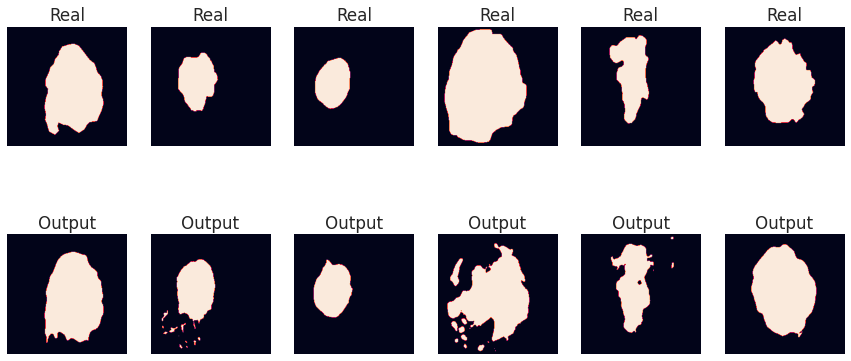

epoch:   4%|▎         | 1/28 [00:04<01:50,  4.10s/it]


Epoch 001 train_loss: 0.5316     val_loss 0.6581 train_iou 0.4877 val_iou 0.0000


epoch:   7%|▋         | 2/28 [00:08<01:46,  4.11s/it]


Epoch 002 train_loss: 0.3634     val_loss 0.6198 train_iou 0.6027 val_iou 0.0461


epoch:  11%|█         | 3/28 [00:12<01:42,  4.11s/it]


Epoch 003 train_loss: 0.3065     val_loss 1.0240 train_iou 0.6755 val_iou 0.4252


epoch:  14%|█▍        | 4/28 [00:16<01:38,  4.11s/it]


Epoch 004 train_loss: 0.2614     val_loss 0.6892 train_iou 0.6970 val_iou 0.2044


epoch:  18%|█▊        | 5/28 [00:20<01:34,  4.11s/it]


Epoch 005 train_loss: 0.2780     val_loss 17.1651 train_iou 0.6805 val_iou 0.3849


epoch:  21%|██▏       | 6/28 [00:24<01:30,  4.11s/it]


Epoch 006 train_loss: 0.2460     val_loss 1.0898 train_iou 0.7118 val_iou 0.4732


epoch:  25%|██▌       | 7/28 [00:28<01:26,  4.10s/it]


Epoch 007 train_loss: 0.2605     val_loss 0.6846 train_iou 0.7122 val_iou 0.5027


epoch:  29%|██▊       | 8/28 [00:32<01:22,  4.10s/it]


Epoch 008 train_loss: 0.2347     val_loss 0.3973 train_iou 0.7202 val_iou 0.5517


epoch:  32%|███▏      | 9/28 [00:36<01:18,  4.11s/it]


Epoch 009 train_loss: 0.2285     val_loss 0.3260 train_iou 0.7351 val_iou 0.5986


epoch:  36%|███▌      | 10/28 [00:41<01:14,  4.11s/it]


Epoch 010 train_loss: 0.2180     val_loss 0.3009 train_iou 0.7354 val_iou 0.6347


epoch:  39%|███▉      | 11/28 [00:45<01:09,  4.11s/it]


Epoch 011 train_loss: 0.2146     val_loss 0.2848 train_iou 0.7381 val_iou 0.6644


epoch:  43%|████▎     | 12/28 [00:49<01:05,  4.11s/it]


Epoch 012 train_loss: 0.2223     val_loss 0.2708 train_iou 0.7378 val_iou 0.6917


epoch:  46%|████▋     | 13/28 [00:53<01:01,  4.11s/it]


Epoch 013 train_loss: 0.2062     val_loss 0.2607 train_iou 0.7451 val_iou 0.7120


epoch:  50%|█████     | 14/28 [00:57<00:57,  4.12s/it]


Epoch 014 train_loss: 0.2303     val_loss 0.2528 train_iou 0.7238 val_iou 0.7304


epoch:  54%|█████▎    | 15/28 [01:01<00:53,  4.12s/it]


Epoch 015 train_loss: 0.2338     val_loss 0.2504 train_iou 0.7235 val_iou 0.7384


epoch:  57%|█████▋    | 16/28 [01:05<00:49,  4.11s/it]


Epoch 016 train_loss: 0.2185     val_loss 0.2496 train_iou 0.7350 val_iou 0.7422


epoch:  61%|██████    | 17/28 [01:09<00:45,  4.11s/it]


Epoch 017 train_loss: 0.2223     val_loss 0.2495 train_iou 0.7310 val_iou 0.7445


epoch:  64%|██████▍   | 18/28 [01:13<00:41,  4.11s/it]


Epoch 018 train_loss: 0.2172     val_loss 0.2495 train_iou 0.7426 val_iou 0.7457


epoch:  68%|██████▊   | 19/28 [01:18<00:36,  4.11s/it]


Epoch 019 train_loss: 0.2090     val_loss 0.2499 train_iou 0.7351 val_iou 0.7468


epoch:  71%|███████▏  | 20/28 [01:22<00:32,  4.10s/it]


Epoch 020 train_loss: 0.2284     val_loss 0.2494 train_iou 0.7344 val_iou 0.7466


epoch:  75%|███████▌  | 21/28 [01:26<00:28,  4.10s/it]


Epoch 021 train_loss: 0.2428     val_loss 0.2498 train_iou 0.7205 val_iou 0.7470


epoch:  79%|███████▊  | 22/28 [01:30<00:24,  4.10s/it]


Epoch 022 train_loss: 0.2031     val_loss 0.2497 train_iou 0.7470 val_iou 0.7472


epoch:  82%|████████▏ | 23/28 [01:34<00:20,  4.10s/it]


Epoch 023 train_loss: 0.2174     val_loss 0.2495 train_iou 0.7400 val_iou 0.7470


epoch:  86%|████████▌ | 24/28 [01:38<00:16,  4.10s/it]


Epoch 024 train_loss: 0.2186     val_loss 0.2493 train_iou 0.7352 val_iou 0.7469


epoch:  89%|████████▉ | 25/28 [01:42<00:12,  4.10s/it]


Epoch 025 train_loss: 0.2325     val_loss 0.2495 train_iou 0.7330 val_iou 0.7470


epoch:  93%|█████████▎| 26/28 [01:46<00:08,  4.10s/it]


Epoch 026 train_loss: 0.2294     val_loss 0.2493 train_iou 0.7236 val_iou 0.7469


epoch:  96%|█████████▋| 27/28 [01:50<00:04,  4.11s/it]


Epoch 027 train_loss: 0.2164     val_loss 0.2492 train_iou 0.7430 val_iou 0.7467


epoch: 100%|██████████| 28/28 [01:55<00:00,  4.11s/it]



Epoch 028 train_loss: 0.2055     val_loss 0.2493 train_iou 0.7523 val_iou 0.7467


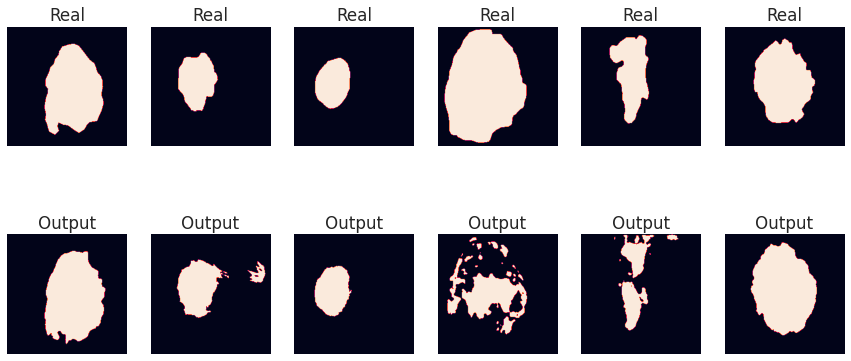

epoch:   4%|▎         | 1/28 [00:04<01:50,  4.10s/it]


Epoch 001 train_loss: 0.4514     val_loss 0.5965 train_iou 0.4713 val_iou 0.0000


epoch:   7%|▋         | 2/28 [00:08<01:46,  4.10s/it]


Epoch 002 train_loss: 0.3139     val_loss 0.4548 train_iou 0.5667 val_iou 0.3727


epoch:  11%|█         | 3/28 [00:12<01:42,  4.11s/it]


Epoch 003 train_loss: 0.2622     val_loss 0.7562 train_iou 0.6474 val_iou 0.0436


epoch:  14%|█▍        | 4/28 [00:16<01:38,  4.10s/it]


Epoch 004 train_loss: 0.2340     val_loss 0.6402 train_iou 0.6577 val_iou 0.2262


epoch:  18%|█▊        | 5/28 [00:20<01:34,  4.10s/it]


Epoch 005 train_loss: 0.1848     val_loss 0.4850 train_iou 0.7341 val_iou 0.3939


epoch:  21%|██▏       | 6/28 [00:24<01:30,  4.10s/it]


Epoch 006 train_loss: 0.1747     val_loss 0.2920 train_iou 0.7441 val_iou 0.5447


epoch:  25%|██▌       | 7/28 [00:28<01:26,  4.10s/it]


Epoch 007 train_loss: 0.1856     val_loss 0.3778 train_iou 0.7200 val_iou 0.4155


epoch:  29%|██▊       | 8/28 [00:32<01:22,  4.11s/it]


Epoch 008 train_loss: 0.1456     val_loss 0.2932 train_iou 0.7592 val_iou 0.5247


epoch:  32%|███▏      | 9/28 [00:36<01:18,  4.11s/it]


Epoch 009 train_loss: 0.1353     val_loss 0.2032 train_iou 0.7733 val_iou 0.6723


epoch:  36%|███▌      | 10/28 [00:41<01:13,  4.10s/it]


Epoch 010 train_loss: 0.1629     val_loss 0.1494 train_iou 0.7610 val_iou 0.7589


epoch:  39%|███▉      | 11/28 [00:45<01:10,  4.12s/it]


Epoch 011 train_loss: 0.1299     val_loss 0.1271 train_iou 0.7927 val_iou 0.7944


epoch:  43%|████▎     | 12/28 [00:49<01:05,  4.12s/it]


Epoch 012 train_loss: 0.1415     val_loss 0.1198 train_iou 0.7806 val_iou 0.8039


epoch:  46%|████▋     | 13/28 [00:53<01:01,  4.12s/it]


Epoch 013 train_loss: 0.1334     val_loss 0.1212 train_iou 0.7986 val_iou 0.7992


epoch:  50%|█████     | 14/28 [00:57<00:57,  4.12s/it]


Epoch 014 train_loss: 0.1334     val_loss 0.1194 train_iou 0.7946 val_iou 0.8005


epoch:  54%|█████▎    | 15/28 [01:01<00:53,  4.11s/it]


Epoch 015 train_loss: 0.1252     val_loss 0.1176 train_iou 0.8060 val_iou 0.8040


epoch:  57%|█████▋    | 16/28 [01:05<00:49,  4.11s/it]


Epoch 016 train_loss: 0.1117     val_loss 0.1169 train_iou 0.8159 val_iou 0.8056


epoch:  61%|██████    | 17/28 [01:09<00:45,  4.11s/it]


Epoch 017 train_loss: 0.1229     val_loss 0.1165 train_iou 0.8062 val_iou 0.8067


epoch:  64%|██████▍   | 18/28 [01:13<00:41,  4.11s/it]


Epoch 018 train_loss: 0.1115     val_loss 0.1159 train_iou 0.8123 val_iou 0.8080


epoch:  68%|██████▊   | 19/28 [01:18<00:36,  4.10s/it]


Epoch 019 train_loss: 0.1269     val_loss 0.1147 train_iou 0.8021 val_iou 0.8097


epoch:  71%|███████▏  | 20/28 [01:22<00:32,  4.10s/it]


Epoch 020 train_loss: 0.1152     val_loss 0.1140 train_iou 0.8141 val_iou 0.8105


epoch:  75%|███████▌  | 21/28 [01:26<00:28,  4.10s/it]


Epoch 021 train_loss: 0.1190     val_loss 0.1135 train_iou 0.8091 val_iou 0.8110


epoch:  79%|███████▊  | 22/28 [01:30<00:24,  4.11s/it]


Epoch 022 train_loss: 0.1227     val_loss 0.1136 train_iou 0.8012 val_iou 0.8110


epoch:  82%|████████▏ | 23/28 [01:34<00:20,  4.11s/it]


Epoch 023 train_loss: 0.1228     val_loss 0.1131 train_iou 0.8033 val_iou 0.8118


epoch:  86%|████████▌ | 24/28 [01:38<00:16,  4.11s/it]


Epoch 024 train_loss: 0.1118     val_loss 0.1130 train_iou 0.8192 val_iou 0.8118


epoch:  89%|████████▉ | 25/28 [01:42<00:12,  4.11s/it]


Epoch 025 train_loss: 0.1263     val_loss 0.1130 train_iou 0.7953 val_iou 0.8117


epoch:  93%|█████████▎| 26/28 [01:46<00:08,  4.11s/it]


Epoch 026 train_loss: 0.1257     val_loss 0.1134 train_iou 0.8038 val_iou 0.8113


epoch:  96%|█████████▋| 27/28 [01:50<00:04,  4.10s/it]


Epoch 027 train_loss: 0.1269     val_loss 0.1137 train_iou 0.7948 val_iou 0.8107


epoch: 100%|██████████| 28/28 [01:55<00:00,  4.11s/it]



Epoch 028 train_loss: 0.1242     val_loss 0.1129 train_iou 0.8098 val_iou 0.8120


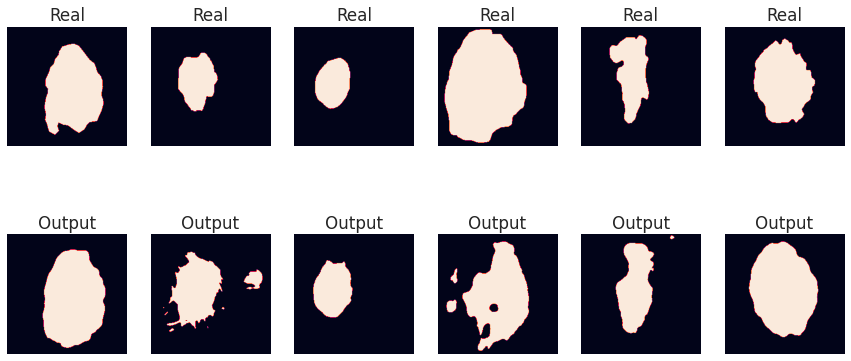

epoch:   4%|▎         | 1/28 [00:04<01:50,  4.09s/it]


Epoch 001 train_loss: 0.4558     val_loss 0.4666 train_iou 0.4599 val_iou 0.0002


epoch:   7%|▋         | 2/28 [00:08<01:46,  4.09s/it]


Epoch 002 train_loss: 0.2424     val_loss 0.3903 train_iou 0.5757 val_iou 0.0000


epoch:  11%|█         | 3/28 [00:12<01:42,  4.10s/it]


Epoch 003 train_loss: 0.2019     val_loss 0.4101 train_iou 0.6557 val_iou 0.0438


epoch:  14%|█▍        | 4/28 [00:16<01:38,  4.10s/it]


Epoch 004 train_loss: 0.1820     val_loss 0.5658 train_iou 0.6569 val_iou 0.1705


epoch:  18%|█▊        | 5/28 [00:20<01:34,  4.09s/it]


Epoch 005 train_loss: 0.1767     val_loss 0.5691 train_iou 0.6667 val_iou 0.1872


epoch:  21%|██▏       | 6/28 [00:24<01:30,  4.09s/it]


Epoch 006 train_loss: 0.1815     val_loss 0.4380 train_iou 0.6931 val_iou 0.4627


epoch:  25%|██▌       | 7/28 [00:28<01:25,  4.09s/it]


Epoch 007 train_loss: 0.1817     val_loss 0.5141 train_iou 0.6796 val_iou 0.4435


epoch:  29%|██▊       | 8/28 [00:32<01:21,  4.10s/it]


Epoch 008 train_loss: 0.1645     val_loss 0.3288 train_iou 0.6720 val_iou 0.5099


epoch:  32%|███▏      | 9/28 [00:36<01:17,  4.10s/it]


Epoch 009 train_loss: 0.1527     val_loss 0.2390 train_iou 0.6855 val_iou 0.5776


epoch:  36%|███▌      | 10/28 [00:40<01:13,  4.10s/it]


Epoch 010 train_loss: 0.1626     val_loss 0.2043 train_iou 0.6889 val_iou 0.6244


epoch:  39%|███▉      | 11/28 [00:45<01:09,  4.11s/it]


Epoch 011 train_loss: 0.1510     val_loss 0.1889 train_iou 0.6991 val_iou 0.6578


epoch:  43%|████▎     | 12/28 [00:49<01:05,  4.10s/it]


Epoch 012 train_loss: 0.1475     val_loss 0.1837 train_iou 0.7115 val_iou 0.6798


epoch:  46%|████▋     | 13/28 [00:53<01:01,  4.11s/it]


Epoch 013 train_loss: 0.1529     val_loss 0.1789 train_iou 0.7021 val_iou 0.6978


epoch:  50%|█████     | 14/28 [00:57<00:57,  4.11s/it]


Epoch 014 train_loss: 0.1437     val_loss 0.1756 train_iou 0.7180 val_iou 0.7119


epoch:  54%|█████▎    | 15/28 [01:01<00:53,  4.12s/it]


Epoch 015 train_loss: 0.1509     val_loss 0.1752 train_iou 0.7149 val_iou 0.7197


epoch:  57%|█████▋    | 16/28 [01:05<00:49,  4.12s/it]


Epoch 016 train_loss: 0.1655     val_loss 0.1751 train_iou 0.6935 val_iou 0.7242


epoch:  61%|██████    | 17/28 [01:09<00:45,  4.12s/it]


Epoch 017 train_loss: 0.1395     val_loss 0.1751 train_iou 0.7244 val_iou 0.7278


epoch:  64%|██████▍   | 18/28 [01:13<00:41,  4.11s/it]


Epoch 018 train_loss: 0.1449     val_loss 0.1750 train_iou 0.7194 val_iou 0.7291


epoch:  68%|██████▊   | 19/28 [01:18<00:37,  4.12s/it]


Epoch 019 train_loss: 0.1460     val_loss 0.1750 train_iou 0.7078 val_iou 0.7299


epoch:  71%|███████▏  | 20/28 [01:22<00:32,  4.12s/it]


Epoch 020 train_loss: 0.1523     val_loss 0.1748 train_iou 0.7087 val_iou 0.7297


epoch:  75%|███████▌  | 21/28 [01:26<00:28,  4.11s/it]


Epoch 021 train_loss: 0.1510     val_loss 0.1748 train_iou 0.7112 val_iou 0.7304


epoch:  79%|███████▊  | 22/28 [01:30<00:24,  4.12s/it]


Epoch 022 train_loss: 0.1413     val_loss 0.1748 train_iou 0.7275 val_iou 0.7312


epoch:  82%|████████▏ | 23/28 [01:34<00:20,  4.13s/it]


Epoch 023 train_loss: 0.1512     val_loss 0.1747 train_iou 0.7158 val_iou 0.7305


epoch:  86%|████████▌ | 24/28 [01:38<00:16,  4.13s/it]


Epoch 024 train_loss: 0.1401     val_loss 0.1745 train_iou 0.7242 val_iou 0.7304


epoch:  89%|████████▉ | 25/28 [01:42<00:12,  4.14s/it]


Epoch 025 train_loss: 0.1425     val_loss 0.1745 train_iou 0.7191 val_iou 0.7303


epoch:  93%|█████████▎| 26/28 [01:46<00:08,  4.14s/it]


Epoch 026 train_loss: 0.1441     val_loss 0.1747 train_iou 0.7286 val_iou 0.7314


epoch:  96%|█████████▋| 27/28 [01:51<00:04,  4.14s/it]


Epoch 027 train_loss: 0.1441     val_loss 0.1747 train_iou 0.7283 val_iou 0.7309


epoch: 100%|██████████| 28/28 [01:55<00:00,  4.12s/it]



Epoch 028 train_loss: 0.1424     val_loss 0.1748 train_iou 0.7189 val_iou 0.7307


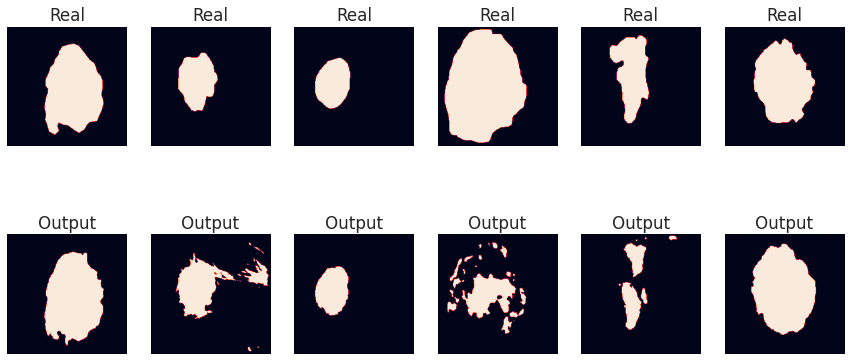

In [ ]:
torch.cuda.empty_cache()
model = UNet1().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_tver = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=FocalTverskyLoss)

torch.cuda.empty_cache()
model = UNet1().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_bce = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=bce_loss)

torch.cuda.empty_cache()
model = UNet1().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_dice = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=dice_loss)

torch.cuda.empty_cache()
model = UNet1().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_focal = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=focal_loss)

train_loss_tver_u1, train_iou_tver_u1, val_loss_tver_u1, val_iou_tver_u1 = zip(*history_tver)
train_loss_bce_u1, train_iou_bce_u1, val_loss_bce_u1, val_iou_bce_u1 = zip(*history_bce)
train_loss_dice_u1, train_iou_dice_u1, val_loss_dice_u1, val_iou_dice_u1 = zip(*history_dice)
train_loss_focal_u1, train_iou_focal_u1, val_loss_focal_u1, val_iou_focal_u1 = zip(*history_focal)

In [ ]:
score_model(model, iou_pytorch, val_dataloader)

0.8214173913002014

epoch:   4%|▎         | 1/28 [00:04<01:56,  4.31s/it]


Epoch 001 train_loss: 0.4695     val_loss 0.5883 train_iou 0.4576 val_iou 0.0003


epoch:   7%|▋         | 2/28 [00:08<01:52,  4.32s/it]


Epoch 002 train_loss: 0.3439     val_loss 0.6192 train_iou 0.5627 val_iou 0.1339


epoch:  11%|█         | 3/28 [00:12<01:48,  4.32s/it]


Epoch 003 train_loss: 0.2781     val_loss 0.4689 train_iou 0.5909 val_iou 0.2642


epoch:  14%|█▍        | 4/28 [00:17<01:43,  4.32s/it]


Epoch 004 train_loss: 0.2161     val_loss 0.3866 train_iou 0.7140 val_iou 0.4241


epoch:  18%|█▊        | 5/28 [00:21<01:39,  4.33s/it]


Epoch 005 train_loss: 0.1970     val_loss 0.3445 train_iou 0.7189 val_iou 0.4619


epoch:  21%|██▏       | 6/28 [00:25<01:35,  4.33s/it]


Epoch 006 train_loss: 0.1778     val_loss 0.5009 train_iou 0.7195 val_iou 0.2707


epoch:  25%|██▌       | 7/28 [00:30<01:30,  4.33s/it]


Epoch 007 train_loss: 0.1759     val_loss 0.2420 train_iou 0.7287 val_iou 0.6243


epoch:  29%|██▊       | 8/28 [00:34<01:26,  4.33s/it]


Epoch 008 train_loss: 0.1828     val_loss 0.1856 train_iou 0.7255 val_iou 0.7001


epoch:  32%|███▏      | 9/28 [00:38<01:22,  4.33s/it]


Epoch 009 train_loss: 0.1695     val_loss 0.1709 train_iou 0.7347 val_iou 0.7195


epoch:  36%|███▌      | 10/28 [00:43<01:17,  4.33s/it]


Epoch 010 train_loss: 0.1369     val_loss 0.1570 train_iou 0.7637 val_iou 0.7377


epoch:  39%|███▉      | 11/28 [00:47<01:13,  4.34s/it]


Epoch 011 train_loss: 0.1435     val_loss 0.1521 train_iou 0.7637 val_iou 0.7447


epoch:  43%|████▎     | 12/28 [00:51<01:09,  4.34s/it]


Epoch 012 train_loss: 0.1425     val_loss 0.1435 train_iou 0.7604 val_iou 0.7573


epoch:  46%|████▋     | 13/28 [00:56<01:05,  4.33s/it]


Epoch 013 train_loss: 0.1475     val_loss 0.1381 train_iou 0.7565 val_iou 0.7657


epoch:  50%|█████     | 14/28 [01:00<01:00,  4.33s/it]


Epoch 014 train_loss: 0.1251     val_loss 0.1363 train_iou 0.7886 val_iou 0.7693


epoch:  54%|█████▎    | 15/28 [01:04<00:56,  4.33s/it]


Epoch 015 train_loss: 0.1619     val_loss 0.1324 train_iou 0.7548 val_iou 0.7752


epoch:  57%|█████▋    | 16/28 [01:09<00:51,  4.33s/it]


Epoch 016 train_loss: 0.1400     val_loss 0.1308 train_iou 0.7726 val_iou 0.7775


epoch:  61%|██████    | 17/28 [01:13<00:47,  4.33s/it]


Epoch 017 train_loss: 0.1423     val_loss 0.1306 train_iou 0.7698 val_iou 0.7776


epoch:  64%|██████▍   | 18/28 [01:17<00:43,  4.33s/it]


Epoch 018 train_loss: 0.1277     val_loss 0.1310 train_iou 0.7840 val_iou 0.7771


epoch:  68%|██████▊   | 19/28 [01:22<00:38,  4.33s/it]


Epoch 019 train_loss: 0.1415     val_loss 0.1311 train_iou 0.7746 val_iou 0.7770


epoch:  71%|███████▏  | 20/28 [01:26<00:34,  4.33s/it]


Epoch 020 train_loss: 0.1223     val_loss 0.1309 train_iou 0.7864 val_iou 0.7770


epoch:  75%|███████▌  | 21/28 [01:30<00:30,  4.33s/it]


Epoch 021 train_loss: 0.1263     val_loss 0.1310 train_iou 0.7833 val_iou 0.7767


epoch:  79%|███████▊  | 22/28 [01:35<00:25,  4.33s/it]


Epoch 022 train_loss: 0.1315     val_loss 0.1307 train_iou 0.7785 val_iou 0.7771


epoch:  82%|████████▏ | 23/28 [01:39<00:21,  4.33s/it]


Epoch 023 train_loss: 0.1271     val_loss 0.1310 train_iou 0.7863 val_iou 0.7767


epoch:  86%|████████▌ | 24/28 [01:43<00:17,  4.33s/it]


Epoch 024 train_loss: 0.1273     val_loss 0.1307 train_iou 0.7871 val_iou 0.7768


epoch:  89%|████████▉ | 25/28 [01:48<00:12,  4.33s/it]


Epoch 025 train_loss: 0.1422     val_loss 0.1304 train_iou 0.7714 val_iou 0.7771


epoch:  93%|█████████▎| 26/28 [01:52<00:08,  4.34s/it]


Epoch 026 train_loss: 0.1327     val_loss 0.1306 train_iou 0.7749 val_iou 0.7766


epoch:  96%|█████████▋| 27/28 [01:56<00:04,  4.34s/it]


Epoch 027 train_loss: 0.1223     val_loss 0.1307 train_iou 0.7890 val_iou 0.7766


epoch: 100%|██████████| 28/28 [02:01<00:00,  4.33s/it]



Epoch 028 train_loss: 0.1412     val_loss 0.1306 train_iou 0.7634 val_iou 0.7770


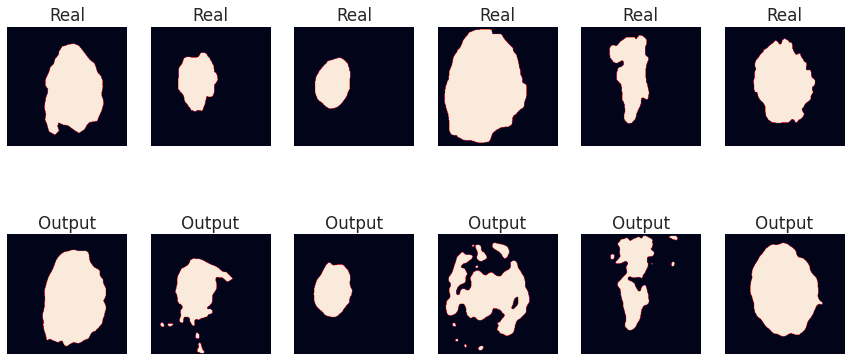

epoch:   4%|▎         | 1/28 [00:04<01:57,  4.33s/it]


Epoch 001 train_loss: 0.4955     val_loss 0.6225 train_iou 0.5043 val_iou 0.0000


epoch:   7%|▋         | 2/28 [00:08<01:52,  4.34s/it]


Epoch 002 train_loss: 0.3428     val_loss 0.6624 train_iou 0.6037 val_iou 0.0000


epoch:  11%|█         | 3/28 [00:13<01:48,  4.34s/it]


Epoch 003 train_loss: 0.3258     val_loss 0.5834 train_iou 0.6199 val_iou 0.0424


epoch:  14%|█▍        | 4/28 [00:17<01:44,  4.35s/it]


Epoch 004 train_loss: 0.2911     val_loss 0.6970 train_iou 0.6549 val_iou 0.1435


epoch:  18%|█▊        | 5/28 [00:21<01:40,  4.36s/it]


Epoch 005 train_loss: 0.2483     val_loss 0.5390 train_iou 0.7012 val_iou 0.3636


epoch:  21%|██▏       | 6/28 [00:26<01:36,  4.37s/it]


Epoch 006 train_loss: 0.2457     val_loss 0.5112 train_iou 0.7187 val_iou 0.5287


epoch:  25%|██▌       | 7/28 [00:30<01:31,  4.37s/it]


Epoch 007 train_loss: 0.2316     val_loss 0.5176 train_iou 0.7135 val_iou 0.5743


epoch:  29%|██▊       | 8/28 [00:34<01:27,  4.37s/it]


Epoch 008 train_loss: 0.2438     val_loss 0.3053 train_iou 0.7389 val_iou 0.6784


epoch:  32%|███▏      | 9/28 [00:39<01:22,  4.36s/it]


Epoch 009 train_loss: 0.2079     val_loss 0.2633 train_iou 0.7624 val_iou 0.7061


epoch:  36%|███▌      | 10/28 [00:43<01:18,  4.37s/it]


Epoch 010 train_loss: 0.2122     val_loss 0.2532 train_iou 0.7499 val_iou 0.7227


epoch:  39%|███▉      | 11/28 [00:48<01:14,  4.38s/it]


Epoch 011 train_loss: 0.2118     val_loss 0.2422 train_iou 0.7557 val_iou 0.7397


epoch:  43%|████▎     | 12/28 [00:52<01:09,  4.37s/it]


Epoch 012 train_loss: 0.2143     val_loss 0.2346 train_iou 0.7548 val_iou 0.7497


epoch:  46%|████▋     | 13/28 [00:56<01:05,  4.38s/it]


Epoch 013 train_loss: 0.2319     val_loss 0.2299 train_iou 0.7414 val_iou 0.7612


epoch:  50%|█████     | 14/28 [01:01<01:01,  4.38s/it]


Epoch 014 train_loss: 0.2184     val_loss 0.2297 train_iou 0.7508 val_iou 0.7617


epoch:  54%|█████▎    | 15/28 [01:05<00:56,  4.38s/it]


Epoch 015 train_loss: 0.2112     val_loss 0.2278 train_iou 0.7510 val_iou 0.7651


epoch:  57%|█████▋    | 16/28 [01:09<00:52,  4.36s/it]


Epoch 016 train_loss: 0.2024     val_loss 0.2274 train_iou 0.7531 val_iou 0.7670


epoch:  61%|██████    | 17/28 [01:14<00:47,  4.36s/it]


Epoch 017 train_loss: 0.2062     val_loss 0.2279 train_iou 0.7520 val_iou 0.7664


epoch:  64%|██████▍   | 18/28 [01:18<00:43,  4.35s/it]


Epoch 018 train_loss: 0.1934     val_loss 0.2281 train_iou 0.7675 val_iou 0.7665


epoch:  68%|██████▊   | 19/28 [01:22<00:39,  4.34s/it]


Epoch 019 train_loss: 0.1983     val_loss 0.2280 train_iou 0.7563 val_iou 0.7666


epoch:  71%|███████▏  | 20/28 [01:27<00:34,  4.34s/it]


Epoch 020 train_loss: 0.2039     val_loss 0.2279 train_iou 0.7587 val_iou 0.7676


epoch:  75%|███████▌  | 21/28 [01:31<00:30,  4.35s/it]


Epoch 021 train_loss: 0.1939     val_loss 0.2277 train_iou 0.7701 val_iou 0.7684


epoch:  79%|███████▊  | 22/28 [01:35<00:26,  4.35s/it]


Epoch 022 train_loss: 0.2013     val_loss 0.2277 train_iou 0.7635 val_iou 0.7682


epoch:  82%|████████▏ | 23/28 [01:40<00:21,  4.34s/it]


Epoch 023 train_loss: 0.1990     val_loss 0.2278 train_iou 0.7617 val_iou 0.7685


epoch:  86%|████████▌ | 24/28 [01:44<00:17,  4.34s/it]


Epoch 024 train_loss: 0.1896     val_loss 0.2277 train_iou 0.7820 val_iou 0.7694


epoch:  89%|████████▉ | 25/28 [01:48<00:13,  4.34s/it]


Epoch 025 train_loss: 0.1984     val_loss 0.2276 train_iou 0.7654 val_iou 0.7692


epoch:  93%|█████████▎| 26/28 [01:53<00:08,  4.33s/it]


Epoch 026 train_loss: 0.1923     val_loss 0.2274 train_iou 0.7758 val_iou 0.7690


epoch:  96%|█████████▋| 27/28 [01:57<00:04,  4.33s/it]


Epoch 027 train_loss: 0.1955     val_loss 0.2276 train_iou 0.7656 val_iou 0.7688


epoch: 100%|██████████| 28/28 [02:01<00:00,  4.35s/it]



Epoch 028 train_loss: 0.2226     val_loss 0.2279 train_iou 0.7442 val_iou 0.7690


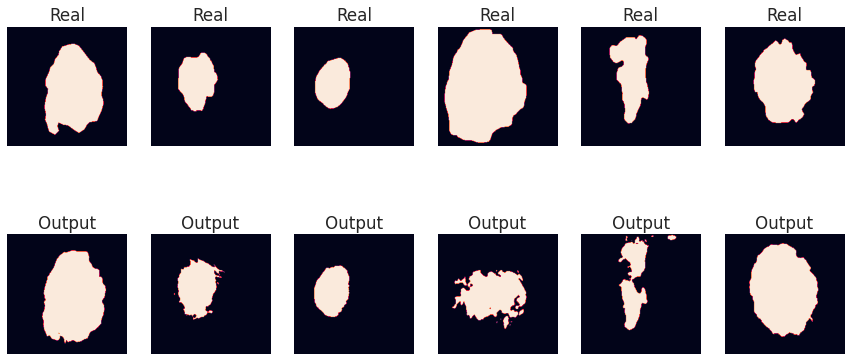

epoch:   4%|▎         | 1/28 [00:04<01:56,  4.30s/it]


Epoch 001 train_loss: 0.4647     val_loss 0.6014 train_iou 0.4478 val_iou 0.0000


epoch:   7%|▋         | 2/28 [00:08<01:52,  4.32s/it]


Epoch 002 train_loss: 0.3390     val_loss 0.7035 train_iou 0.5395 val_iou 0.0000


epoch:  11%|█         | 3/28 [00:12<01:47,  4.32s/it]


Epoch 003 train_loss: 0.2787     val_loss 0.8010 train_iou 0.5907 val_iou 0.0000


epoch:  14%|█▍        | 4/28 [00:17<01:43,  4.32s/it]


Epoch 004 train_loss: 0.2383     val_loss 0.5731 train_iou 0.6671 val_iou 0.1575


epoch:  18%|█▊        | 5/28 [00:21<01:39,  4.33s/it]


Epoch 005 train_loss: 0.1856     val_loss 0.3878 train_iou 0.7348 val_iou 0.3812


epoch:  21%|██▏       | 6/28 [00:25<01:35,  4.33s/it]


Epoch 006 train_loss: 0.1828     val_loss 0.3254 train_iou 0.7409 val_iou 0.4715


epoch:  25%|██▌       | 7/28 [00:30<01:30,  4.33s/it]


Epoch 007 train_loss: 0.1550     val_loss 0.3349 train_iou 0.7433 val_iou 0.4473


epoch:  29%|██▊       | 8/28 [00:34<01:26,  4.33s/it]


Epoch 008 train_loss: 0.1648     val_loss 0.2741 train_iou 0.7317 val_iou 0.5598


epoch:  32%|███▏      | 9/28 [00:38<01:22,  4.33s/it]


Epoch 009 train_loss: 0.1429     val_loss 0.2308 train_iou 0.7542 val_iou 0.6335


epoch:  36%|███▌      | 10/28 [00:43<01:17,  4.33s/it]


Epoch 010 train_loss: 0.1434     val_loss 0.1992 train_iou 0.7587 val_iou 0.6809


epoch:  39%|███▉      | 11/28 [00:47<01:13,  4.33s/it]


Epoch 011 train_loss: 0.1571     val_loss 0.1758 train_iou 0.7701 val_iou 0.7112


epoch:  43%|████▎     | 12/28 [00:51<01:09,  4.32s/it]


Epoch 012 train_loss: 0.1563     val_loss 0.1615 train_iou 0.7608 val_iou 0.7299


epoch:  46%|████▋     | 13/28 [00:56<01:04,  4.32s/it]


Epoch 013 train_loss: 0.1571     val_loss 0.1511 train_iou 0.7647 val_iou 0.7437


epoch:  50%|█████     | 14/28 [01:00<01:00,  4.32s/it]


Epoch 014 train_loss: 0.1376     val_loss 0.1427 train_iou 0.7660 val_iou 0.7554


epoch:  54%|█████▎    | 15/28 [01:04<00:56,  4.32s/it]


Epoch 015 train_loss: 0.1391     val_loss 0.1403 train_iou 0.7737 val_iou 0.7622


epoch:  57%|█████▋    | 16/28 [01:09<00:51,  4.32s/it]


Epoch 016 train_loss: 0.1267     val_loss 0.1404 train_iou 0.7773 val_iou 0.7641


epoch:  61%|██████    | 17/28 [01:13<00:47,  4.32s/it]


Epoch 017 train_loss: 0.1410     val_loss 0.1409 train_iou 0.7690 val_iou 0.7642


epoch:  64%|██████▍   | 18/28 [01:17<00:43,  4.33s/it]


Epoch 018 train_loss: 0.1359     val_loss 0.1410 train_iou 0.7755 val_iou 0.7641


epoch:  68%|██████▊   | 19/28 [01:22<00:38,  4.32s/it]


Epoch 019 train_loss: 0.1345     val_loss 0.1414 train_iou 0.7686 val_iou 0.7638


epoch:  71%|███████▏  | 20/28 [01:26<00:34,  4.32s/it]


Epoch 020 train_loss: 0.1501     val_loss 0.1417 train_iou 0.7571 val_iou 0.7635


epoch:  75%|███████▌  | 21/28 [01:30<00:30,  4.33s/it]


Epoch 021 train_loss: 0.1420     val_loss 0.1422 train_iou 0.7686 val_iou 0.7632


epoch:  79%|███████▊  | 22/28 [01:35<00:25,  4.33s/it]


Epoch 022 train_loss: 0.1347     val_loss 0.1422 train_iou 0.7667 val_iou 0.7632


epoch:  82%|████████▏ | 23/28 [01:39<00:21,  4.33s/it]


Epoch 023 train_loss: 0.1420     val_loss 0.1422 train_iou 0.7649 val_iou 0.7634


epoch:  86%|████████▌ | 24/28 [01:43<00:17,  4.33s/it]


Epoch 024 train_loss: 0.1509     val_loss 0.1425 train_iou 0.7508 val_iou 0.7632


epoch:  89%|████████▉ | 25/28 [01:48<00:12,  4.32s/it]


Epoch 025 train_loss: 0.1363     val_loss 0.1426 train_iou 0.7655 val_iou 0.7631


epoch:  93%|█████████▎| 26/28 [01:52<00:08,  4.32s/it]


Epoch 026 train_loss: 0.1384     val_loss 0.1426 train_iou 0.7747 val_iou 0.7632


epoch:  96%|█████████▋| 27/28 [01:56<00:04,  4.32s/it]


Epoch 027 train_loss: 0.1550     val_loss 0.1432 train_iou 0.7478 val_iou 0.7628


epoch: 100%|██████████| 28/28 [02:01<00:00,  4.32s/it]



Epoch 028 train_loss: 0.1489     val_loss 0.1427 train_iou 0.7468 val_iou 0.7630


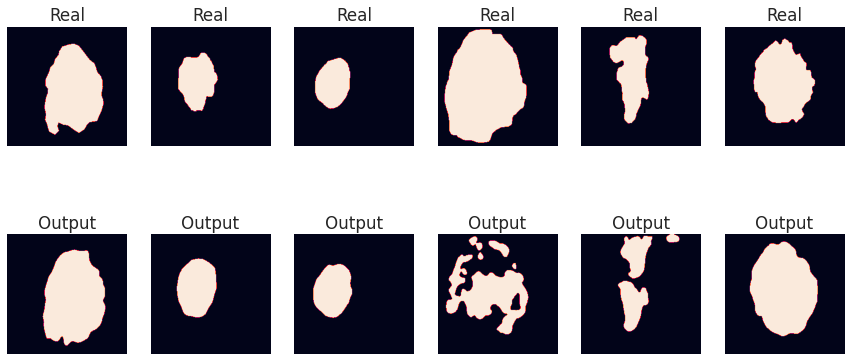

epoch:   4%|▎         | 1/28 [00:04<01:56,  4.31s/it]


Epoch 001 train_loss: 0.3414     val_loss 0.4194 train_iou 0.4299 val_iou 0.0000


epoch:   7%|▋         | 2/28 [00:08<01:52,  4.32s/it]


Epoch 002 train_loss: 0.2251     val_loss 0.4709 train_iou 0.6265 val_iou 0.0000


epoch:  11%|█         | 3/28 [00:12<01:47,  4.32s/it]


Epoch 003 train_loss: 0.1843     val_loss 0.5854 train_iou 0.6607 val_iou 0.0029


epoch:  14%|█▍        | 4/28 [00:17<01:43,  4.33s/it]


Epoch 004 train_loss: 0.1758     val_loss 0.6368 train_iou 0.6878 val_iou 0.0436


epoch:  18%|█▊        | 5/28 [00:21<01:39,  4.32s/it]


Epoch 005 train_loss: 0.1664     val_loss 0.5068 train_iou 0.7171 val_iou 0.1314


epoch:  21%|██▏       | 6/28 [00:25<01:35,  4.33s/it]


Epoch 006 train_loss: 0.1734     val_loss 0.4202 train_iou 0.6908 val_iou 0.2036


epoch:  25%|██▌       | 7/28 [00:30<01:30,  4.33s/it]


Epoch 007 train_loss: 0.1676     val_loss 0.3498 train_iou 0.6664 val_iou 0.3760


epoch:  29%|██▊       | 8/28 [00:34<01:26,  4.33s/it]


Epoch 008 train_loss: 0.1635     val_loss 0.2796 train_iou 0.6765 val_iou 0.4720


epoch:  32%|███▏      | 9/28 [00:38<01:22,  4.34s/it]


Epoch 009 train_loss: 0.1464     val_loss 0.2292 train_iou 0.7038 val_iou 0.5420


epoch:  36%|███▌      | 10/28 [00:43<01:18,  4.34s/it]


Epoch 010 train_loss: 0.1423     val_loss 0.1994 train_iou 0.7049 val_iou 0.5956


epoch:  39%|███▉      | 11/28 [00:47<01:13,  4.33s/it]


Epoch 011 train_loss: 0.1399     val_loss 0.1846 train_iou 0.7056 val_iou 0.6343


epoch:  43%|████▎     | 12/28 [00:51<01:09,  4.33s/it]


Epoch 012 train_loss: 0.1383     val_loss 0.1732 train_iou 0.7164 val_iou 0.6727


epoch:  46%|████▋     | 13/28 [00:56<01:04,  4.33s/it]


Epoch 013 train_loss: 0.1440     val_loss 0.1651 train_iou 0.7207 val_iou 0.7017


epoch:  50%|█████     | 14/28 [01:00<01:00,  4.33s/it]


Epoch 014 train_loss: 0.1392     val_loss 0.1604 train_iou 0.7282 val_iou 0.7238


epoch:  54%|█████▎    | 15/28 [01:04<00:56,  4.33s/it]


Epoch 015 train_loss: 0.1466     val_loss 0.1593 train_iou 0.7235 val_iou 0.7323


epoch:  57%|█████▋    | 16/28 [01:09<00:51,  4.32s/it]


Epoch 016 train_loss: 0.1401     val_loss 0.1589 train_iou 0.7219 val_iou 0.7380


epoch:  61%|██████    | 17/28 [01:13<00:47,  4.32s/it]


Epoch 017 train_loss: 0.1298     val_loss 0.1591 train_iou 0.7361 val_iou 0.7412


epoch:  64%|██████▍   | 18/28 [01:17<00:43,  4.33s/it]


Epoch 018 train_loss: 0.1376     val_loss 0.1590 train_iou 0.7276 val_iou 0.7427


epoch:  68%|██████▊   | 19/28 [01:22<00:38,  4.33s/it]


Epoch 019 train_loss: 0.1340     val_loss 0.1594 train_iou 0.7413 val_iou 0.7444


epoch:  71%|███████▏  | 20/28 [01:26<00:34,  4.33s/it]


Epoch 020 train_loss: 0.1372     val_loss 0.1594 train_iou 0.7319 val_iou 0.7445


epoch:  75%|███████▌  | 21/28 [01:30<00:30,  4.33s/it]


Epoch 021 train_loss: 0.1349     val_loss 0.1595 train_iou 0.7304 val_iou 0.7462


epoch:  79%|███████▊  | 22/28 [01:35<00:25,  4.33s/it]


Epoch 022 train_loss: 0.1348     val_loss 0.1587 train_iou 0.7349 val_iou 0.7458


epoch:  82%|████████▏ | 23/28 [01:39<00:21,  4.33s/it]


Epoch 023 train_loss: 0.1370     val_loss 0.1583 train_iou 0.7220 val_iou 0.7456


epoch:  86%|████████▌ | 24/28 [01:43<00:17,  4.33s/it]


Epoch 024 train_loss: 0.1391     val_loss 0.1583 train_iou 0.7362 val_iou 0.7468


epoch:  89%|████████▉ | 25/28 [01:48<00:12,  4.33s/it]


Epoch 025 train_loss: 0.1340     val_loss 0.1581 train_iou 0.7259 val_iou 0.7465


epoch:  93%|█████████▎| 26/28 [01:52<00:08,  4.33s/it]


Epoch 026 train_loss: 0.1459     val_loss 0.1582 train_iou 0.7262 val_iou 0.7474


epoch:  96%|█████████▋| 27/28 [01:56<00:04,  4.33s/it]


Epoch 027 train_loss: 0.1281     val_loss 0.1581 train_iou 0.7380 val_iou 0.7467


epoch: 100%|██████████| 28/28 [02:01<00:00,  4.33s/it]



Epoch 028 train_loss: 0.1287     val_loss 0.1583 train_iou 0.7394 val_iou 0.7468


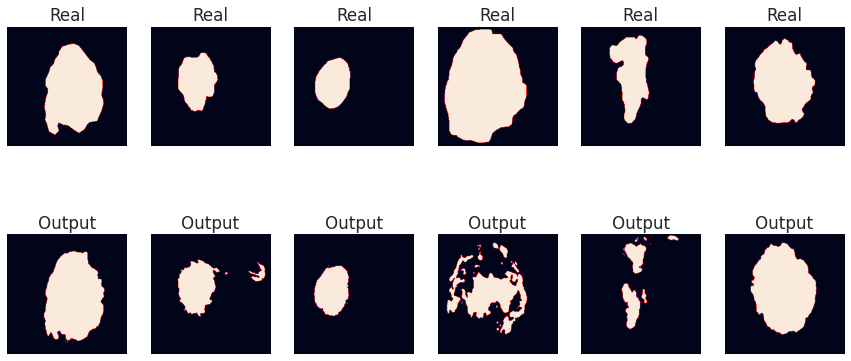

In [ ]:
torch.cuda.empty_cache()
model = UNet2().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_tver = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=FocalTverskyLoss)

torch.cuda.empty_cache()
model = UNet2().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_bce = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=bce_loss)

torch.cuda.empty_cache()
model = UNet2().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_dice = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=dice_loss)

torch.cuda.empty_cache()
model = UNet2().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())
history_focal = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=focal_loss)

train_loss_tver_u2, train_iou_tver_u2, val_loss_tver_u2, val_iou_tver_u2 = zip(*history_tver)
train_loss_bce_u2, train_iou_bce_u2, val_loss_bce_u2, val_iou_bce_u2 = zip(*history_bce)
train_loss_dice_u2, train_iou_dice_u2, val_loss_dice_u2, val_iou_dice_u2 = zip(*history_dice)
train_loss_focal_u2, train_iou_focal_u2, val_loss_focal_u2, val_iou_focal_u2 = zip(*history_focal)

In [ ]:
torch.cuda.empty_cache()
model = UNet1().to(DEVICE)
history_dice = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=dice_loss)

torch.cuda.empty_cache()
model = UNet1().to(DEVICE)
history_focal = train(train_dataloader, val_dataloader, model=model, epochs=28, opt=optimizer, criterion=focal_loss)

train_loss_bce, train_iou_bce, val_loss_bce, val_iou_bce = zip(*history_bce)
train_loss_dice, train_iou_dice, val_loss_dice, val_iou_dice = zip(*history_dice)
train_loss_focal, train_iou_focal, val_loss_focal, val_iou_focal = zip(*history_focal)

## Отчет

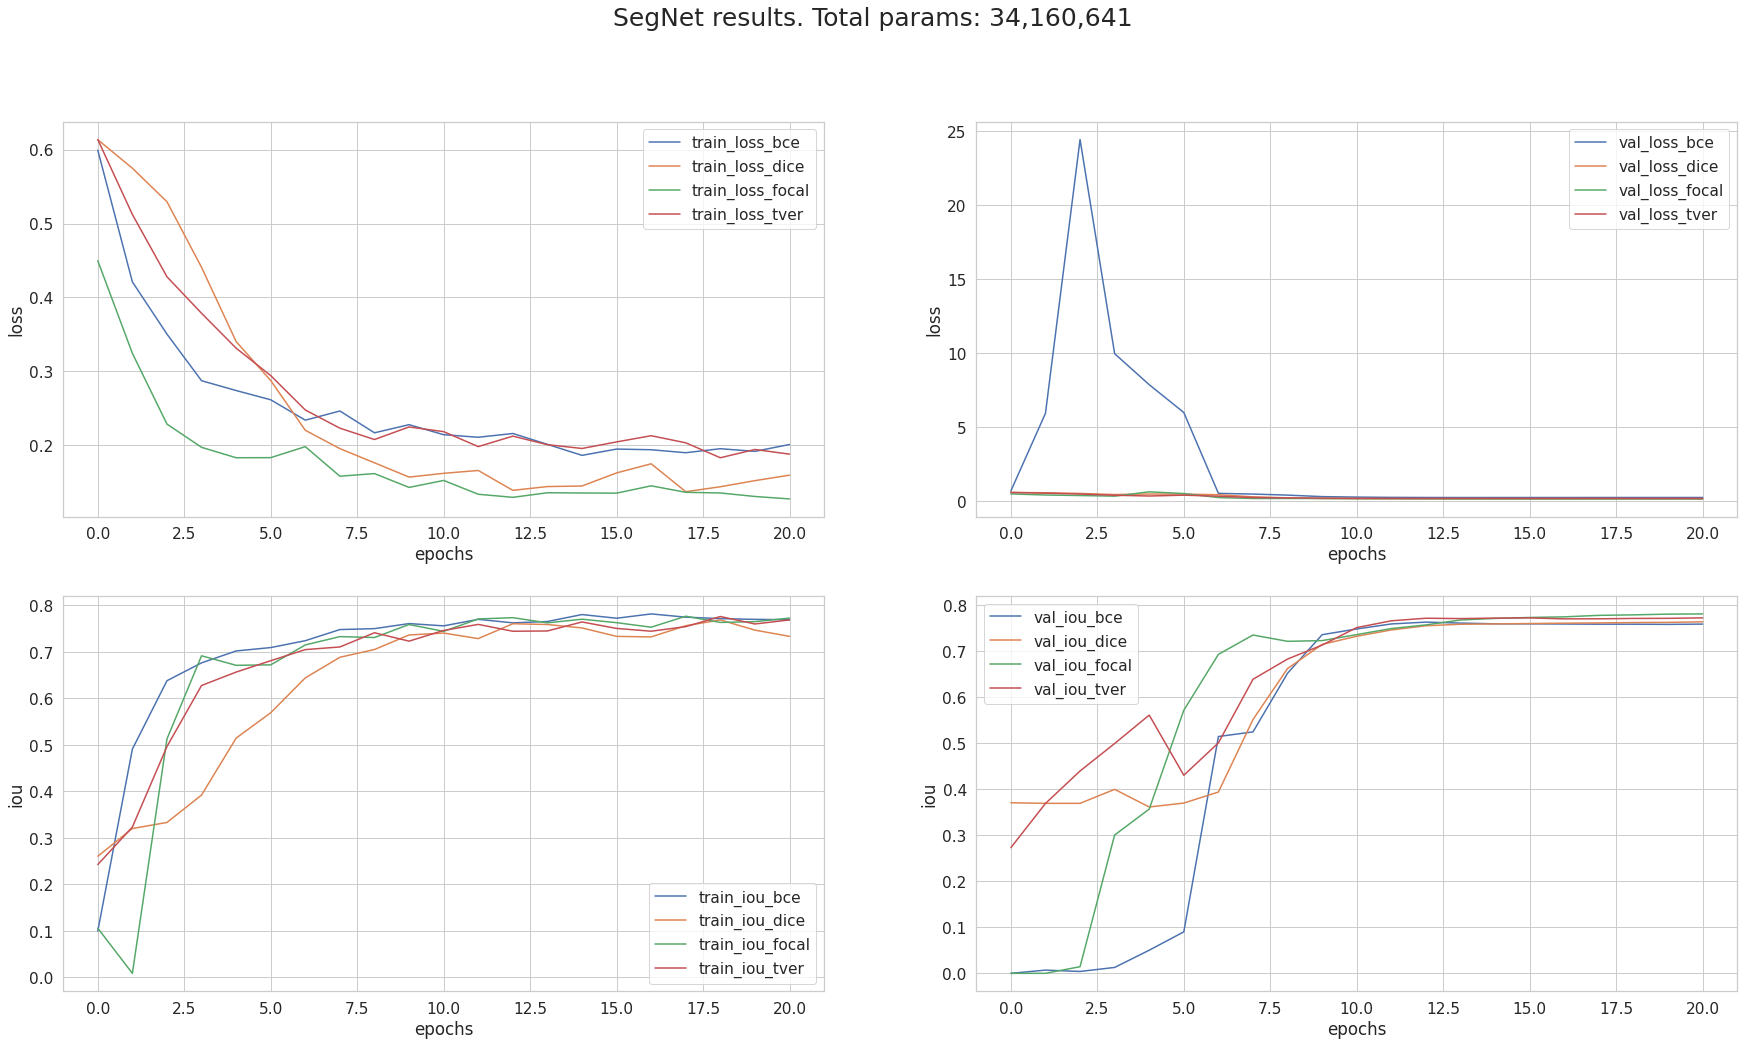

In [ ]:
# Выбираем лучшую среди SegNet

# Лучшая модель SegNet с Focal_loss

 # кривые валидации
f, axes = plt.subplots(2, 2, figsize=(30, 16))

axes = axes.ravel()

f.suptitle("SegNet results. Total params: 34,160,641", fontsize=25)

axes[0].plot(train_loss_bce, label="train_loss_bce")
axes[0].plot(train_loss_dice, label="train_loss_dice")
axes[0].plot(train_loss_focal, label="train_loss_focal")
axes[0].plot(train_loss_tver, label="train_loss_tver")

axes[1].plot(val_loss_bce, label="val_loss_bce")
axes[1].plot(val_loss_dice, label="val_loss_dice")
axes[1].plot(val_loss_focal, label="val_loss_focal")
axes[1].plot(val_loss_tver, label="val_loss_tver")

axes[2].plot(train_iou_bce, label="train_iou_bce")
axes[2].plot(train_iou_dice, label="train_iou_dice")
axes[2].plot(train_iou_focal, label="train_iou_focal")
axes[2].plot(train_iou_tver, label="train_iou_tver")

axes[3].plot(val_iou_bce, label="val_iou_bce")
axes[3].plot(val_iou_dice, label="val_iou_dice")
axes[3].plot(val_iou_focal, label="val_iou_focal")
axes[3].plot(val_iou_tver, label="val_iou_tver")

axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='best')
axes[3].legend(loc='best')

axes[0].set_xlabel("epochs")
axes[0].set_ylabel("loss")
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("loss")
axes[2].set_xlabel("epochs")
axes[2].set_ylabel("iou")
axes[3].set_xlabel("epochs")
axes[3].set_ylabel("iou")

plt.show()

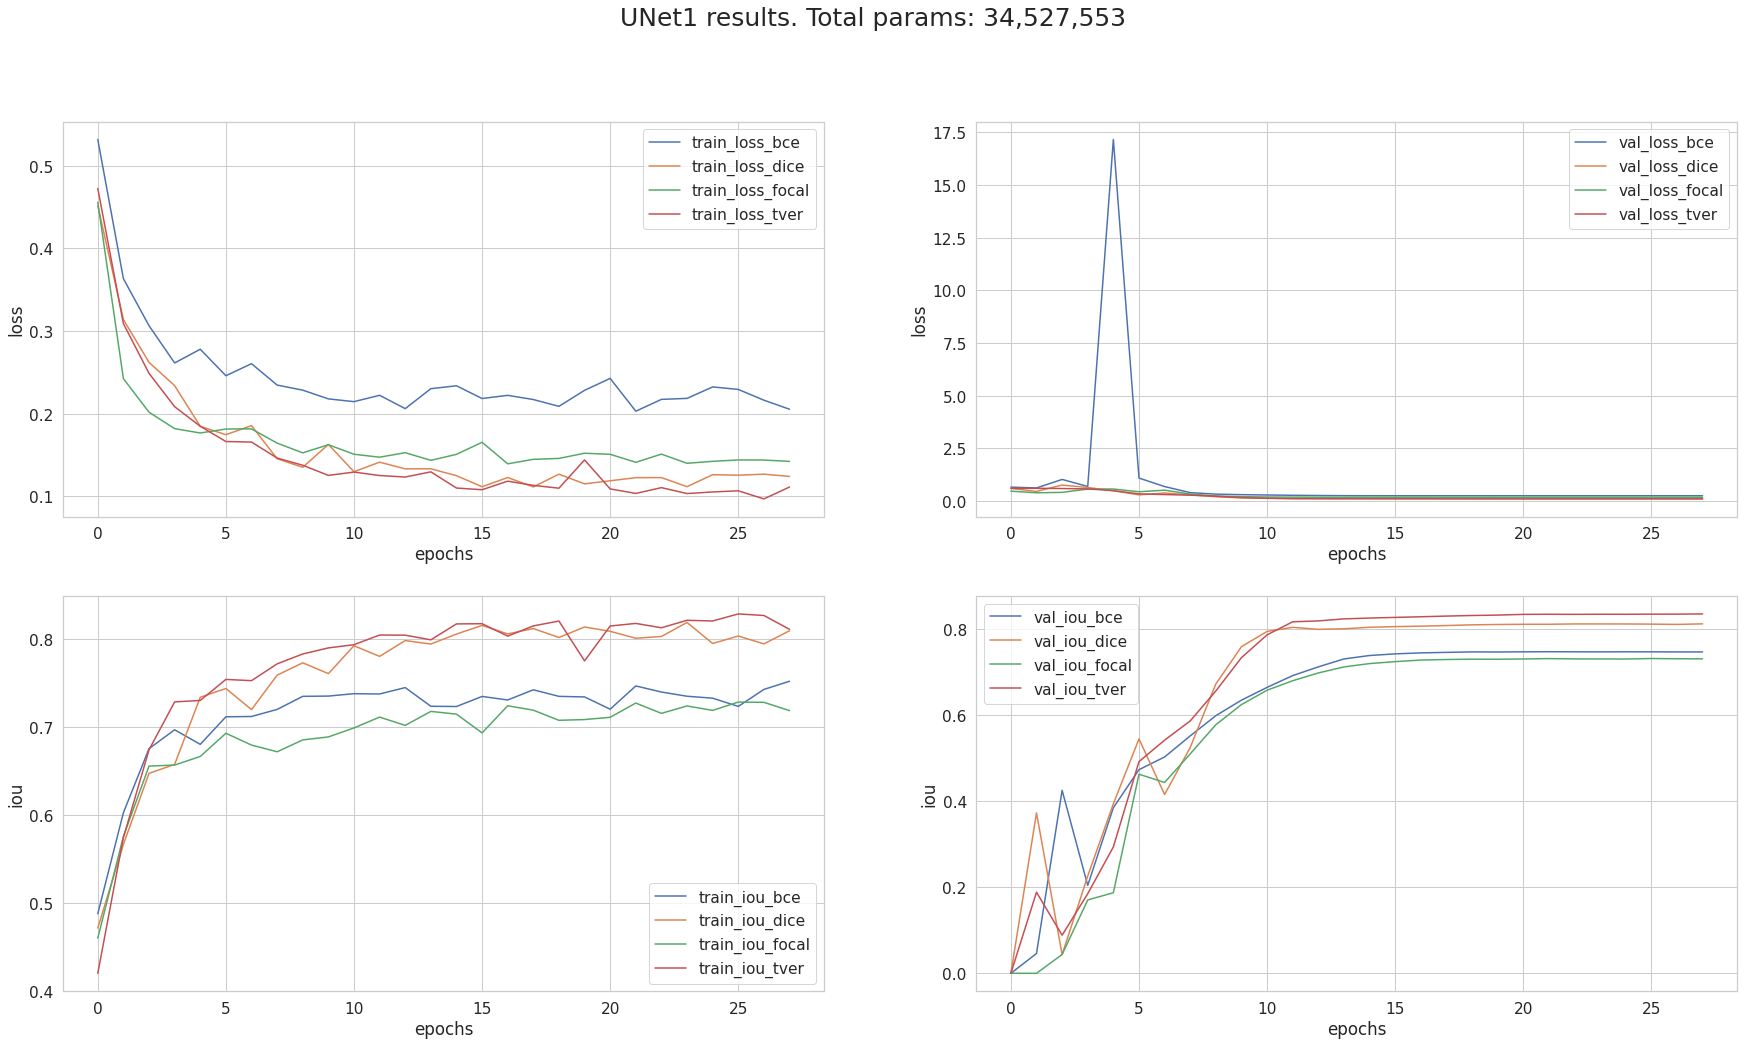

In [ ]:
# Выбираем лучшую среди UNet1

# Лучшая модель UNet1 с tver

 # кривые валидации
f, axes = plt.subplots(2, 2, figsize=(30, 16))

axes = axes.ravel()

f.suptitle("UNet1 results. Total params: 34,527,553", fontsize=25)

axes[0].plot(train_loss_bce_u1, label="train_loss_bce")
axes[0].plot(train_loss_dice_u1, label="train_loss_dice")
axes[0].plot(train_loss_focal_u1, label="train_loss_focal")
axes[0].plot(train_loss_tver_u1, label="train_loss_tver")

axes[1].plot(val_loss_bce_u1, label="val_loss_bce")
axes[1].plot(val_loss_dice_u1, label="val_loss_dice")
axes[1].plot(val_loss_focal_u1, label="val_loss_focal")
axes[1].plot(val_loss_tver_u1, label="val_loss_tver")

axes[2].plot(train_iou_bce_u1, label="train_iou_bce")
axes[2].plot(train_iou_dice_u1, label="train_iou_dice")
axes[2].plot(train_iou_focal_u1, label="train_iou_focal")
axes[2].plot(train_iou_tver_u1, label="train_iou_tver")

axes[3].plot(val_iou_bce_u1, label="val_iou_bce")
axes[3].plot(val_iou_dice_u1, label="val_iou_dice")
axes[3].plot(val_iou_focal_u1, label="val_iou_focal")
axes[3].plot(val_iou_tver_u1, label="val_iou_tver")

axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='best')
axes[3].legend(loc='best')

axes[0].set_xlabel("epochs")
axes[0].set_ylabel("loss")
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("loss")
axes[2].set_xlabel("epochs")
axes[2].set_ylabel("iou")
axes[3].set_xlabel("epochs")
axes[3].set_ylabel("iou")

plt.show()

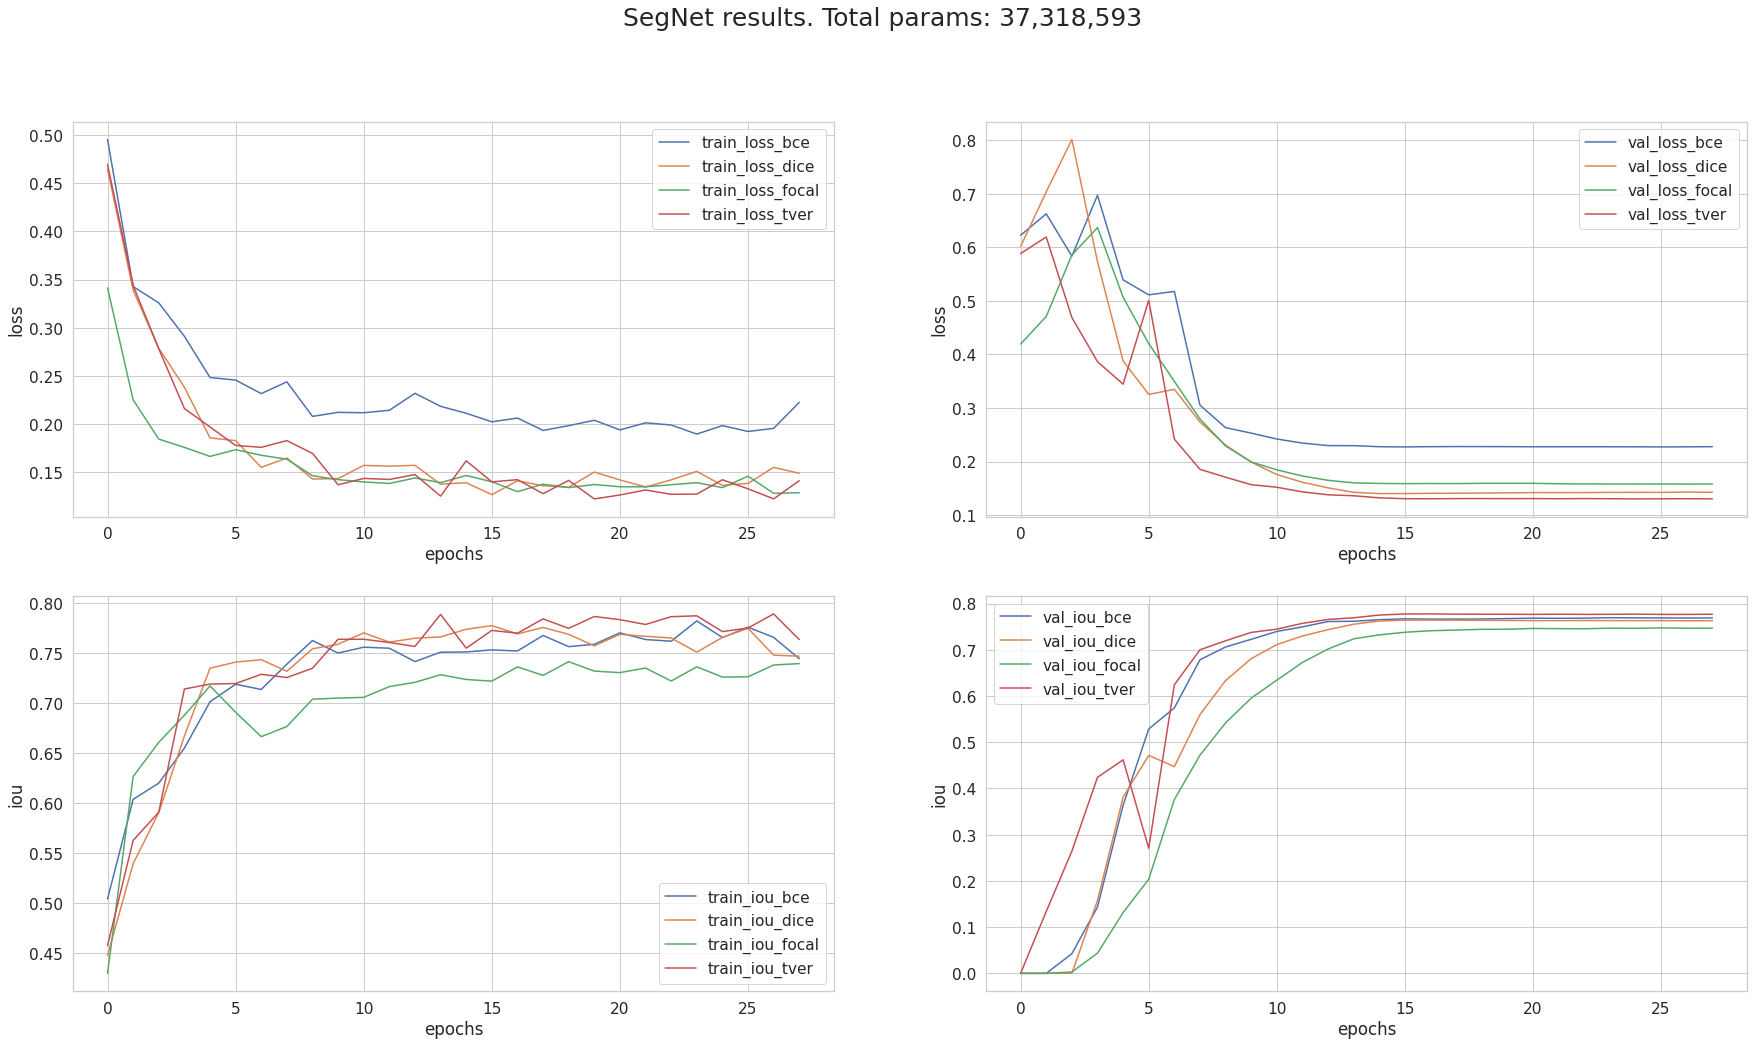

In [ ]:
# Выбираем лучшую среди UNet2

# Лучшая модель UNet2 с tver_loss

 # кривые валидации
f, axes = plt.subplots(2, 2, figsize=(30, 16))

axes = axes.ravel()

f.suptitle("SegNet results. Total params: 37,318,593", fontsize=25)

axes[0].plot(train_loss_bce_u2, label="train_loss_bce")
axes[0].plot(train_loss_dice_u2, label="train_loss_dice")
axes[0].plot(train_loss_focal_u2, label="train_loss_focal")
axes[0].plot(train_loss_tver_u2, label="train_loss_tver")

axes[1].plot(val_loss_bce_u2, label="val_loss_bce")
axes[1].plot(val_loss_dice_u2, label="val_loss_dice")
axes[1].plot(val_loss_focal_u2, label="val_loss_focal")
axes[1].plot(val_loss_tver_u2, label="val_loss_tver")

axes[2].plot(train_iou_bce_u2, label="train_iou_bce")
axes[2].plot(train_iou_dice_u2, label="train_iou_dice")
axes[2].plot(train_iou_focal_u2, label="train_iou_focal")
axes[2].plot(train_iou_tver_u2, label="train_iou_tver")

axes[3].plot(val_iou_bce_u2, label="val_iou_bce")
axes[3].plot(val_iou_dice_u2, label="val_iou_dice")
axes[3].plot(val_iou_focal_u2, label="val_iou_focal")
axes[3].plot(val_iou_tver_u2, label="val_iou_tver")

axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='best')
axes[3].legend(loc='best')

axes[0].set_xlabel("epochs")
axes[0].set_ylabel("loss")
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("loss")
axes[2].set_xlabel("epochs")
axes[2].set_ylabel("iou")
axes[3].set_xlabel("epochs")
axes[3].set_ylabel("iou")

plt.show()

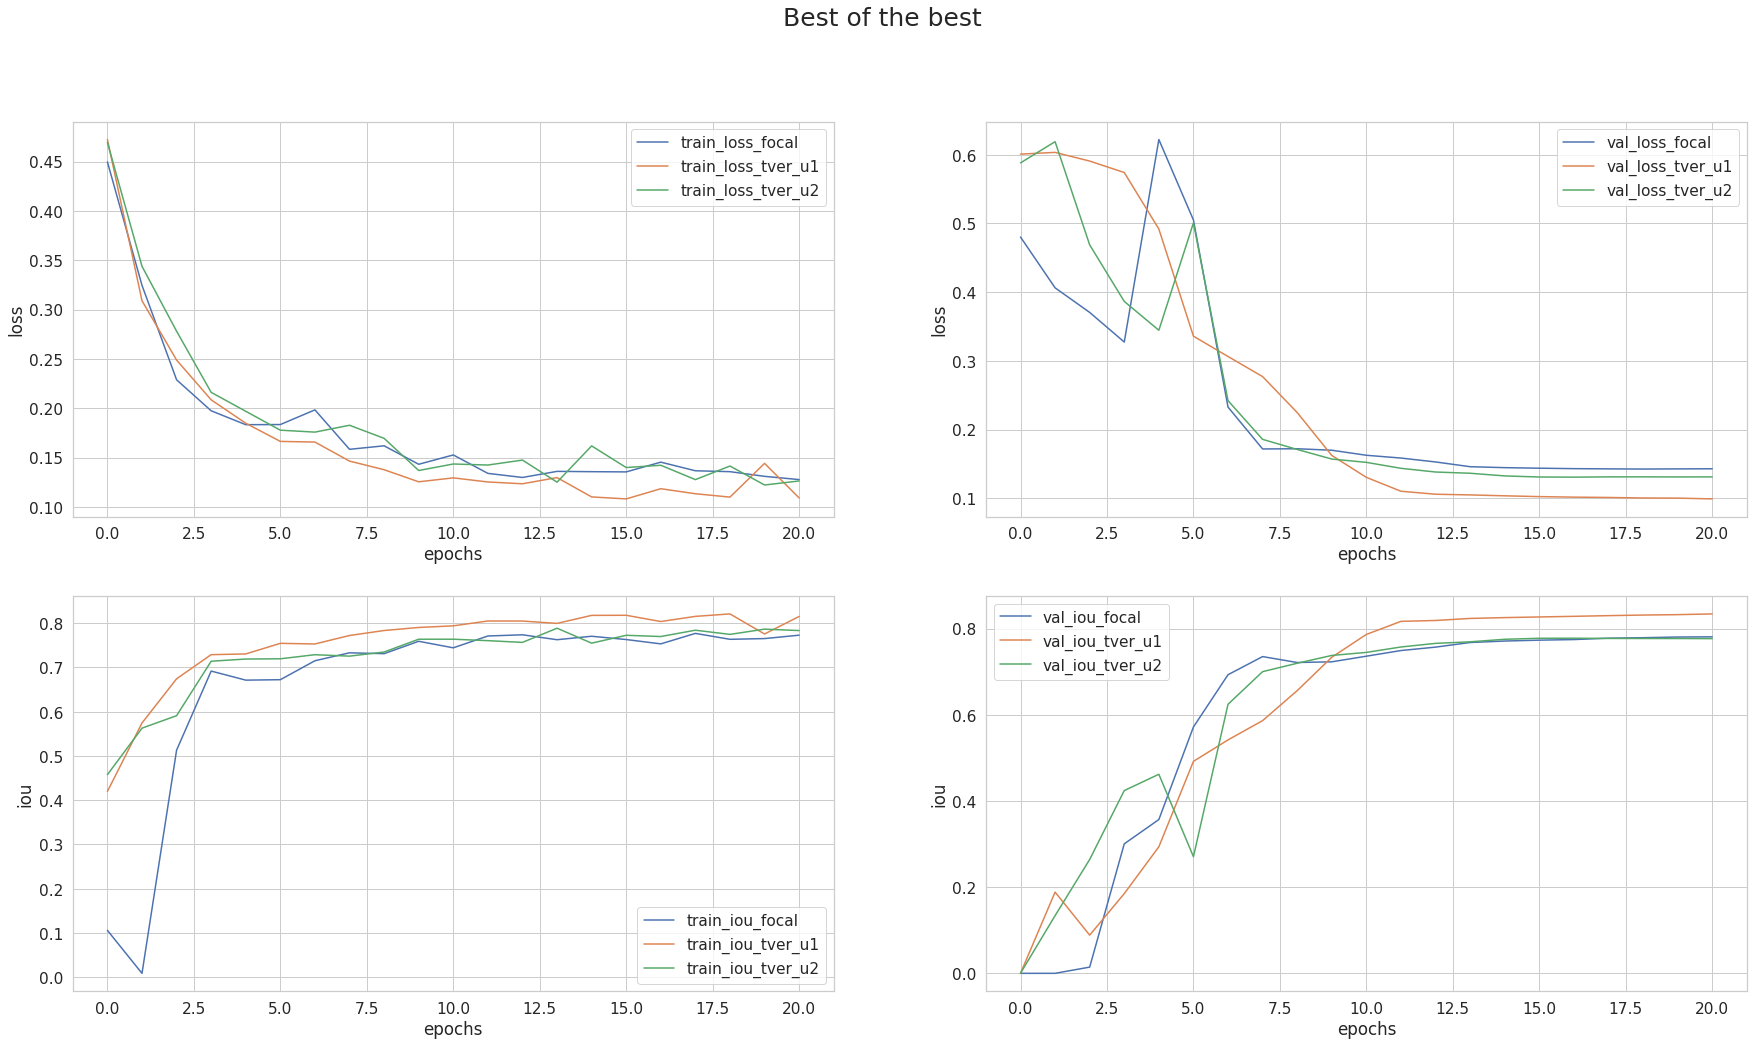

In [ ]:
# Выбираем лучшую среди лучших

# Лучшее качество unet1 с tver loss

f, axes = plt.subplots(2, 2, figsize=(30, 16))

axes = axes.ravel()

f.suptitle("Best of the best", fontsize=25)

axes[0].plot(train_loss_focal, label="train_loss_focal")
axes[0].plot(train_loss_tver_u1[:21], label="train_loss_tver_u1")
axes[0].plot(train_loss_tver_u2[:21], label="train_loss_tver_u2")

axes[1].plot(val_loss_focal, label="val_loss_focal")
axes[1].plot(val_loss_tver_u1[:21], label="val_loss_tver_u1")
axes[1].plot(val_loss_tver_u2[:21], label="val_loss_tver_u2")

axes[2].plot(train_iou_focal, label="train_iou_focal")
axes[2].plot(train_iou_tver_u1[:21], label="train_iou_tver_u1")
axes[2].plot(train_iou_tver_u2[:21], label="train_iou_tver_u2")

axes[3].plot(val_iou_focal, label="val_iou_focal")
axes[3].plot(val_iou_tver_u1[:21], label="val_iou_tver_u1")
axes[3].plot(val_iou_tver_u2[:21], label="val_iou_tver_u2")

axes[0].legend(loc='best')
axes[1].legend(loc='best')
axes[2].legend(loc='best')
axes[3].legend(loc='best')

axes[0].set_xlabel("epochs")
axes[0].set_ylabel("loss")
axes[1].set_xlabel("epochs")
axes[1].set_ylabel("loss")
axes[2].set_xlabel("epochs")
axes[2].set_ylabel("iou")
axes[3].set_xlabel("epochs")
axes[3].set_ylabel("iou")

plt.show()